## 1. Import

In [1]:
# !pip install tqdm -q
# !pip install statsmodels -q

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 한글 폰트 설정
import matplotlib
import matplotlib.font_manager as fm
import platform

# OS 정보
os_name = platform.system()         # Windows / Linux / Darwin
os_version = platform.release()     # 11, 8.1, 22.04 등은 직접 매핑 필요

"""
OS	            NT 버전 (platform.version()의 major.minor 부분)	대표 빌드 번호
Windows 8.0	    6.2	                                            9200
Windows 8.1	    6.3	                                            9600
Windows 10	    10.0	                                        10240 ~ 19045
Windows 11	    10.0	                                        22000 / 22621 / 22631 / 26100
""" 

# C:\Windows\Fonts   # ==> Windows OS에 등록되어 있는 모든 폰트 파일들
if os_name == "Windows":
    # Windows 11 / Windows 8.1 구분하기
    # platform.release()가 10으로 나오는 경우도 있어 version() 검사 필요
    version_detail = platform.version()

    if "10.0" in version_detail:
        # Windows 11 or Windows 10 버전: 10.0
        print("→ Windows 11 (or 10) detected")
        font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS, Windows11 폰트 경로

    elif "6.3" in version_detail:
        # Windows 8.1 버전: 6.3
        print("→ Windows 8.1 detected")
        font_path = 'C:\\Windows\\Fonts\\batang.ttc' # 윈도우 OS, Windows8.1 폰트 경로

    else:
        print("→ Unknown Windows version:", version_detail)
        
# '~/.local/share/fonts/' or '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 22.04 폰트 경로
elif os_name == "Linux":
    # Ubuntu 버전 확인
    import distro   # pip install distro (필요 시)

    linux_name = distro.name()
    linux_version = distro.version()

    if linux_name == "Ubuntu" and linux_version.startswith("22.04"):
        print("→ Ubuntu 22.04 detected")
        font_path = '/home/yypark/.local/share/fonts/D2Coding-Ver1.3.2-20180524.ttf' # Ubuntu 22.04 폰트 경로
    else:
        print(f"→ Other Linux distro: {linux_name} {linux_version}")
        font_path = '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc' # Ubuntu 폰트 경로

else:
    print("Unsupported OS:", os_name)
    

font_prop = fm.FontProperties(fname = font_path) # 폰트경로에 있는 폰트 이름들 뽑아오자.
font_name = font_prop.get_name() # 폰트명

#matplotlib.rc('font', key=value)
matplotlib.rc('font', family=font_name)

# matplotlib이 기본적으로 사용하는 유니코드 마이너스 비활성화
# -> 아스키코드의 마이너스 사용
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지

→ Ubuntu 22.04 detected


## 2. 데이터 전처리

### train.csv 탐색

In [5]:
train = pd.read_csv('../data/train.csv')
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10836 entries, 0 to 10835
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   item_id   10836 non-null  object 
 1   year      10836 non-null  int64  
 2   month     10836 non-null  int64  
 3   seq       10836 non-null  float64
 4   type      10836 non-null  int64  
 5   hs4       10836 non-null  int64  
 6   weight    10836 non-null  float64
 7   quantity  10836 non-null  float64
 8   value     10836 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 762.0+ KB


In [7]:
train.describe()

,year,month,seq,type,hs4,weight,quantity,value
count,10836.000000,10836.000000,10836.000000,10836.0,10836.000000,1.083600e+04,1.083600e+04,1.083600e+04
mean,2023.331395,6.108435,2.034238,1.0,4821.969546,1.098413e+06,8.633771e+04,1.739442e+06
std,1.049357,3.392649,0.813380,0.0,2296.892536,5.153790e+06,7.614669e+06,5.457480e+06
min,2022.000000,1.000000,1.000000,1.0,1210.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.000000,3.000000,1.000000,1.0,2833.000000,3.457500e+02,0.000000e+00,1.150675e+04
50%,2023.000000,6.000000,2.000000,1.0,3824.000000,6.532500e+03,0.000000e+00,1.250070e+05
75%,2024.000000,9.000000,3.000000,1.0,7202.000000,1.555108e+05,0.000000e+00,1.039764e+06
max,2025.000000,12.000000,3.000000,1.0,9403.000000,1.104919e+08,7.925990e+08,1.110414e+08


In [8]:
print(f'train.shape = {train.shape}')
display(train.apply(lambda x: len(np.unique(x)), axis=0))
display(train.apply(lambda x: np.unique(x), axis=0))

train.shape = (10836, 9)


item_id      100
year           4
month         12
seq            3
type           1
hs4           71
weight      7438
quantity    1226
value       9686
dtype: int64

item_id     [AANGBULD, AHMDUILJ, ANWUJOKX, APQGTRMF, ATLDM...
year                                 [2022, 2023, 2024, 2025]
month                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
seq                                           [1.0, 2.0, 3.0]
type                                                      [1]
hs4         [1210, 2002, 2102, 2501, 2529, 2612, 2701, 271...
weight      [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
quantity    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
value       [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
dtype: object

In [9]:
train['hs4'].is_unique, train['hs4'].nunique(), train['hs4'].unique()

(False,
 71,
 array([3038, 2002, 2102, 2501, 2529, 2805, 2807, 2811, 2814, 2825, 2833,
        2836, 2841, 2846, 2847, 2916, 3006, 3102, 3206, 3207, 3215, 3307,
        3404, 3806, 3815, 3824, 3904, 3909, 4202, 4601, 4802, 5111, 5205,
        5309, 5402, 5515, 5602, 5609, 5705, 6101, 6211, 7202, 7207, 8102,
        8105, 8461, 8467, 8479, 8501, 8505, 8527, 8708, 8714, 9403, 1210,
        3813, 4408, 4810, 5512, 2701, 7907, 2710, 6006, 5119, 9022, 4403,
        3003, 2612, 4302, 7142, 3024]))

In [10]:
train['hs4'].value_counts()

hs4
2805    646
3824    535
2811    516
8501    423
8505    387
       ... 
4302      9
7142      8
2612      6
3024      5
3003      2
Name: count, Length: 71, dtype: int64

### monthly data 탐색

In [11]:
# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

monthly.head()

,item_id,year,month,value,ym
0,AANGBULD,2022,1,14276.0,2022-01-01
1,AANGBULD,2022,2,52347.0,2022-02-01
2,AANGBULD,2022,3,53549.0,2022-03-01
3,AANGBULD,2022,5,26997.0,2022-05-01
4,AANGBULD,2022,6,84489.0,2022-06-01


In [12]:
# train = pd.read_csv('../data/train.csv')

# # year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
# monthly = (
#     train
#     .groupby(["item_id", "year", "month"], as_index=False)["value"]
#     .sum()
# )

# # year, month를 하나의 키(ym)로 묶기
# monthly["ym"] = pd.to_datetime(
#     monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
# )

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

pivot.head()

ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


## 3. 공행성쌍 탐색
- 각 (A, B) 쌍에 대해 lag = 1 ~ max_lag까지 Pearson 상관계수 계산
- 절댓값이 가장 큰 상관계수와 lag를 선택
- |corr| >= corr_threshold이면 A→B 공행성 있다고 판단

In [13]:
def plot_histogram(input_var_col: pd.Series|pd.DataFrame, num_bin: int,
                    title_str: str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                    xlbl_str: str = 'following_item 갯수',
                    verbose=False):
    
    if type(input_var_col) == pd.Series: ser = input_var_col
    elif type(input_var_col) == pd.DataFrame: ser = input_var_col.squeeze(axis=1)
    else: 
        print("Wrong input: input should be pd.Series or pd.DataFrame of single column")
        return 
    
    #fig = plt.figure(figsize=(10,10))
    #df_pairs_mod.plot(kind='hist', bins=10)
    # (최대값 - 최소값) / bins
    # plt.hist(scores, bins =10) # bins = 10, 기본값
    count, bins, container = plt.hist(ser, bins=num_bin, edgecolor='k', rwidth=.9) # 
    if verbose:
        print('count :', count) # count : [    1.   2.   1.     3.   3.     3.   2.     5.]
        print('bins :', bins)   # bins :  [60. 64.25 68.5  72.75 77.   81.25 85.5  89.75 94.  ]
        print('container :', container) # container : <BarContainer object of 8 artists>
        for i in range(len(bins)-1):
            print(f'{bins[i]} ~ {bins[i+1]} : {int(count[i])}개')

    plt.xlabel(xlbl_str)
    plt.ylabel('Count')
    #plt.ylim([0, 20])
    #plt.yticks([0, 3, 6, 9, 12, 15, 18])
    plt.grid(axis='y')

    plt.title(title_str)
    plt.show()

In [14]:
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

pairs = find_comovement_pairs(pivot)
print("탐색된 공행성쌍 수:", len(pairs))
pairs.head()

100it [00:07, 13.34it/s]

탐색된 공행성쌍 수: 1425


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,5,-0.443984
1,AANGBULD,DEWLVASR,6,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635
3,AANGBULD,EVBVXETX,6,0.436623
4,AANGBULD,FTSVTTSR,3,0.531400


In [15]:
df_pairs = pairs.groupby('leading_item_id')['following_item_id'] \
    .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
df_pairs    

###
### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
###

dct_pair_detection = {'comv_yes':df_pairs.index.to_list() , 
                      'comv_no': set(train['item_id']).difference(set(df_pairs.index.to_list()))}
print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_detection['comv_no']))
print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_detection['comv_no']))

print("공행성 탐지된 상품수: ", len(dct_pair_detection['comv_yes']))
print("공행성이 탐지된 상품id: ", sorted(dct_pair_detection['comv_yes'])) 

공행성이 탐지되지 않은 상품수:  9
공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  91
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

In [16]:
pivot.loc[list(dct_pair_detection['comv_no'])]

ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
KFQSHBNH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1582651.0,6009875.0,3603019.0,8406385.0,8261094.0,8716645.0,11986087.0
GMBFCMIU,0.0,0.0,0.0,0.0,1130.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
GIKPEWTY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,37570.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QSDCUCLB,0.0,1080.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0
TANNMIMB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PLMZALFA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RJCAXSGH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3669667.0,4275859.0,5013508.0,4577228.0,3790640.0,4441969.0,5038934.0
RUVXNNVA,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,...,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
pivot.loc[list(dct_pair_detection['comv_no'])].apply(lambda x : sum(x>0), axis=1)

item_id
KFQSHBNH     7
GMBFCMIU     1
ANWUJOKX     8
GIKPEWTY     5
QSDCUCLB    10
TANNMIMB     6
PLMZALFA     3
RJCAXSGH     7
RUVXNNVA     3
dtype: int64

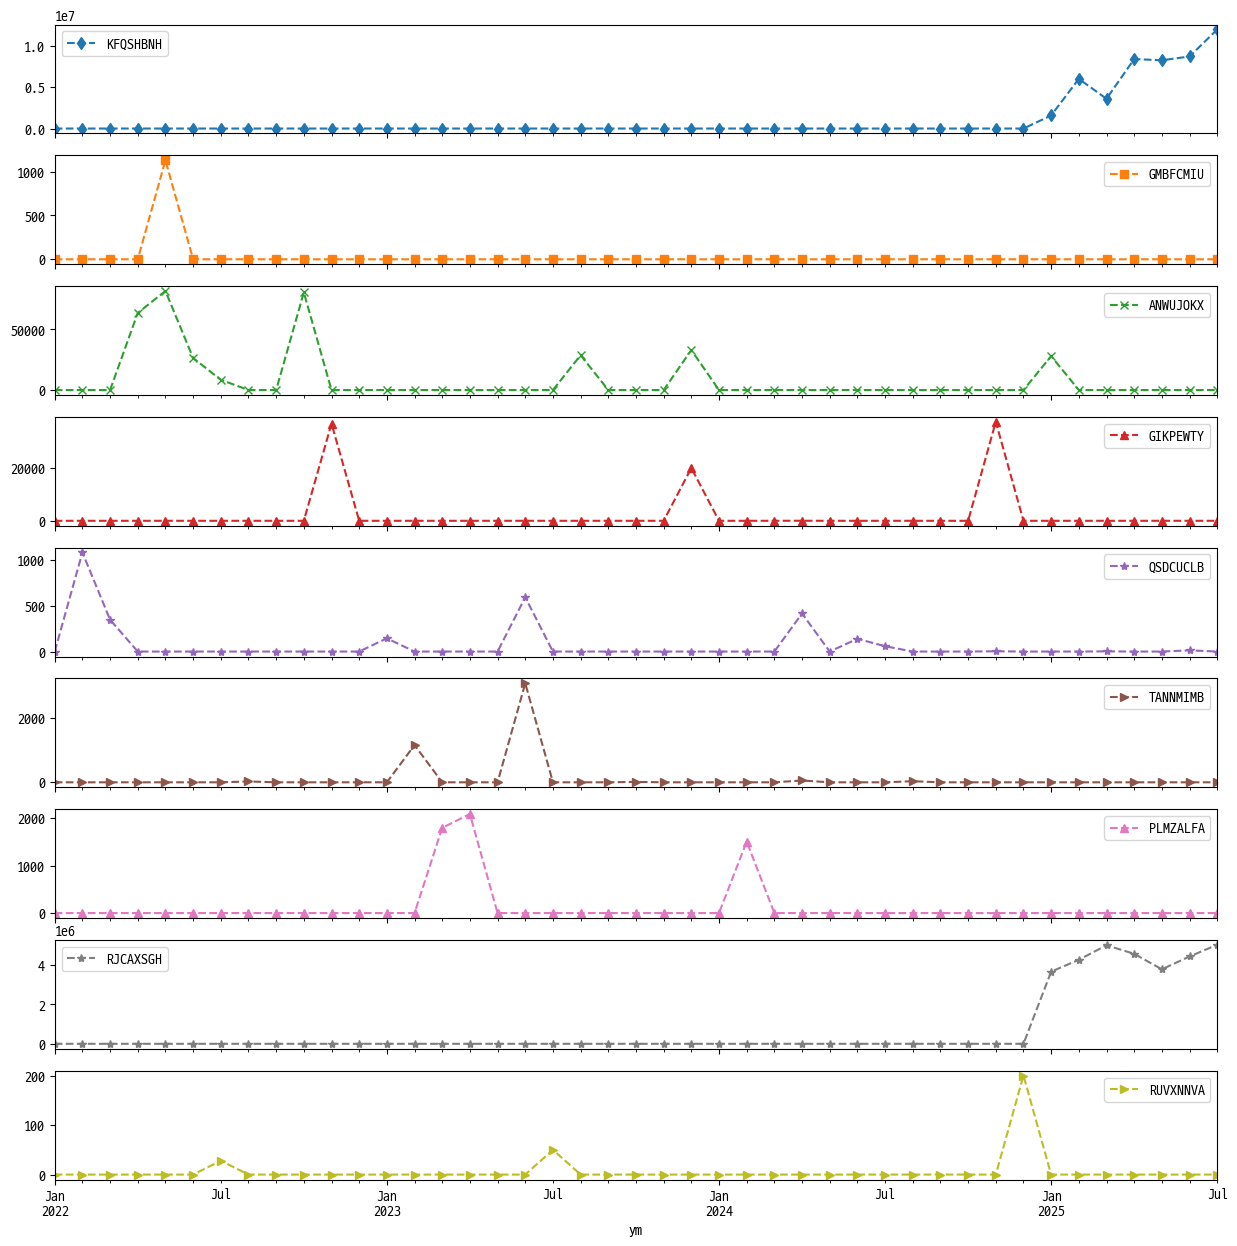

In [18]:
style = ['--d', '--s', '--x', '--^', '--*', '-->',  '--^', '--*', '-->']
pivot.loc[list(dct_pair_detection['comv_no'])].T.plot(figsize=(15, 15), subplots=True, style=style)
#pivot.T.plot(figsize=(15, 15), subplots=True)

plt.show()

In [19]:
print(df_pairs.sum())
df_pairs

size    1425
dtype: int64


,size
leading_item_id,
SDWAYPIK,37
DNMPSKTB,36
QRKRBYJL,34
GYHKIVQT,32
OGAFEHLU,32
...,...
MBSBZBXA,4
YSYHGLQK,4
XIPPENFQ,4


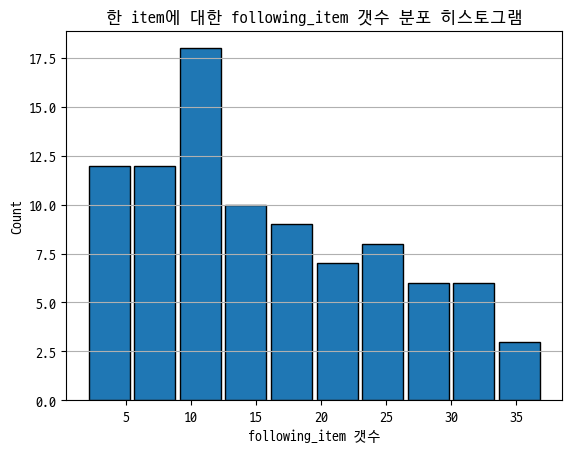

In [20]:
plot_histogram(input_var_col = df_pairs['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

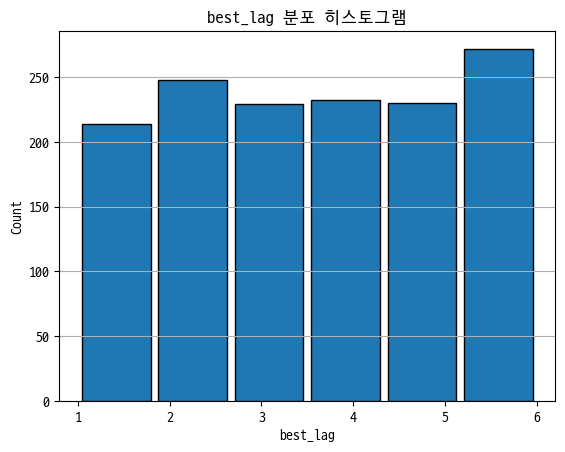

In [21]:
plot_histogram(input_var_col = pairs['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [22]:
##############################################
##### 1) 값대신 변화량 비교하여 pairs 찾기
##### x = np.diff(x_raw), y = np.diff(y_raw) 

# 시간이 지남에 따라 쭉 증가하거나 감소하는 추세(trend)가 있는 데이터 
# (이걸 '불안정하다(Non-stationary)' 또는 '단위근이 있다'고 함)는 
#  서로 아무 관계가 없어도 상관관계가 높게 나오는 경향이 있음
# -> '변화량' (Difference)을 구한다는 건, 
#    그런 데이터에서 '추세(trend)'를 제거해서 안정적인(stationary) 데이터로 만드는 가장 간단한 방법.
############################################## 

# - https://www.nobelprize.org/uploads/2018/06/advanced-economicsciences2003-1.pdf
# 


In [23]:
print(np.diff([1, 3, 6, 11]))
x_raw = pivot.loc["AHMDUILJ"].values.astype(float)
print(x_raw)
np.diff(x_raw)

[2 3 5]
[242705. 120847. 197317. 126142.  71730. 149138. 186617. 169995. 140547.
  89292. 141264.  71149.  68964. 105738. 146741.  81879.  86402. 164052.
  29231. 148893. 205185. 141323. 126401. 144876. 184748. 125214. 104215.
 142205.  42289. 153029.  50048. 168677. 184920. 123085. 143451.  78649.
 125098.  80404. 157401. 115509. 127473.  89479. 101317.]


array([-121858.,   76470.,  -71175.,  -54412.,   77408.,   37479.,
        -16622.,  -29448.,  -51255.,   51972.,  -70115.,   -2185.,
         36774.,   41003.,  -64862.,    4523.,   77650., -134821.,
        119662.,   56292.,  -63862.,  -14922.,   18475.,   39872.,
        -59534.,  -20999.,   37990.,  -99916.,  110740., -102981.,
        118629.,   16243.,  -61835.,   20366.,  -64802.,   46449.,
        -44694.,   76997.,  -41892.,   11964.,  -37994.,   11838.])

In [24]:

def find_comovement_pairs_diff(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        #x = pivot.loc[leader].values.astype(float)
        x_raw = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x_raw) < min_nonzero:
            continue

        x = np.diff(x_raw) # 변화량, 1차분
        for follower in items:
            if follower == leader:
                continue

            #y = pivot.loc[follower].values.astype(float)
            y_raw = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y_raw) < min_nonzero:
                continue
            
            y = np.diff(y_raw) # 변화량, 1차분

            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if (n_months-1) <= lag: # diff로 데이터 1개 줄어서 n_months-1 (43 -> 42)
                    continue
                
                # x_diff[:-lag], y_diff[lag:] 비교
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

pairs_diff = find_comovement_pairs_diff(pivot)
print("탐색된 공행성쌍 수:", len(pairs_diff)) # 1425 -> 1562로 갯수 증가
pairs_diff.head()

100it [00:07, 13.01it/s]

탐색된 공행성쌍 수: 1562


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,6,0.417464
1,AANGBULD,BJALXPFS,6,0.524327
2,AANGBULD,DEWLVASR,6,0.483517
3,AANGBULD,FTSVTTSR,6,-0.491995
4,AANGBULD,GKQIJYDH,6,0.541411


In [25]:
df_pairs_diff = pairs_diff.groupby('leading_item_id')['following_item_id'] \
    .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
df_pairs_diff    

###
### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
###

dct_pair_diff_detection = {'comv_yes':df_pairs_diff.index.to_list() , 
                      'comv_no': set(train['item_id']).difference(set(df_pairs_diff.index.to_list()))}
print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_diff_detection['comv_no']))
print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_diff_detection['comv_no']))

print("공행성 탐지된 상품수: ", len(dct_pair_diff_detection['comv_yes']))
print("공행성이 탐지된 상품id: ", sorted(dct_pair_diff_detection['comv_yes'])) 

공행성이 탐지되지 않은 상품수:  9
공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  91
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

In [26]:
print(df_pairs_diff.sum())
df_pairs_diff

size    1562
dtype: int64


,size
leading_item_id,
BSRMSVTC,31
EVBVXETX,30
XIIEJNEE,30
ROACSLMG,28
OGAFEHLU,27
...,...
VUAFAIYJ,8
VWMBASNE,7
DBWLZWNK,6


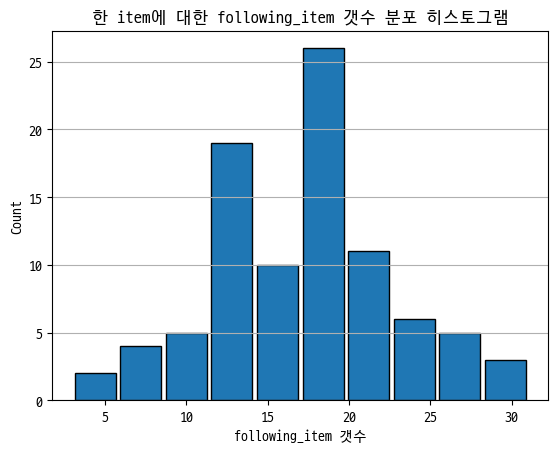

In [27]:
plot_histogram(input_var_col = df_pairs_diff['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

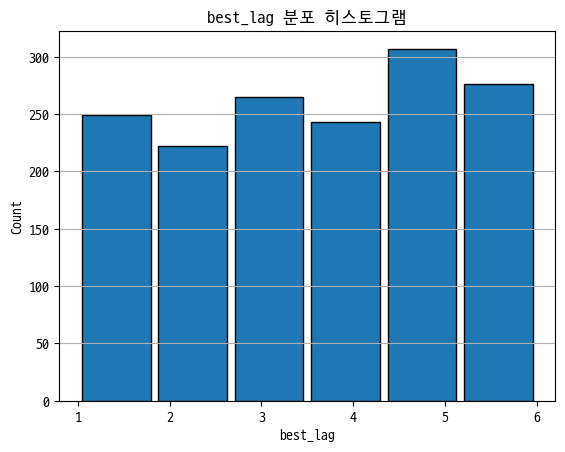

In [28]:
plot_histogram(input_var_col = pairs_diff['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [29]:
#####  기본값: find_comovement_pairs_mod(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4)
def find_comovement_pairs_mod_diff(pivot, max_lag=6, min_lag = 1, min_nonzero=12, corr_threshold=0.4):
    """_summary_
    - 각 (A, B) 쌍에 대해 lag = 0 ~ max_lag까지 Pearson 상관계수 계산
    - 절댓값이 가장 큰 상관계수와 lag를 선택
    - |corr| >= corr_threshold이면 A→B 공행성 있다고 판단
    Args:
        pivot (_type_): _description_
        max_lag (int, optional): _description_. Defaults to 6.
        min_lag (int, optional): _description_. Defaults to 1.
        min_nonzero (int, optional): _description_. Defaults to 12.
        corr_threshold (float, optional): _description_. Defaults to 0.4.

    Returns:
        _type_: _description_
    """
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)

    results = []

    for i, leader in tqdm(enumerate(items)):
        # x = pivot.loc[leader].values.astype(float)
        x_raw = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x_raw) < min_nonzero:
            continue

        x = np.diff(x_raw) # 변화량 1차분 계산, 데이터 1개 줄어듦
        for follower in items:
            if follower == leader:
                continue

            # y = pivot.loc[follower].values.astype(float)
            y_raw = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y_raw) < min_nonzero:
                continue

            y = np.diff(y_raw) # 변화량 1차분 계산, 데이터 1개 줄어듦
            best_lag = None
            best_corr = 0.0

            ## lag = 1 ~ max_lag 탐색
            #for lag in range(1, max_lag + 1):
            # lag = 0 ~ max_lag 탐색
            for lag in range(min_lag, max_lag + 1):
                # if n_months <= lag:
                if (n_months-1) <= lag: # 데이터 1개 줄어서 n_months-1(43 -> 42)
                    continue

                # x_diff[:-lag] 와 y_diff[lag:] 비교
                if lag == 0: corr = safe_corr(x[:], y[lag:])
                else: corr = safe_corr(x[:-lag], y[lag:])
                
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

pairs_mod_diff = find_comovement_pairs_mod_diff(pivot, min_lag = 0)
print("탐색된 공행성쌍 수:", len(pairs_mod_diff)) # 1425 -> 1562 -> 1791로 갯수 증가
pairs_mod_diff.head()

100it [00:08, 11.42it/s]

탐색된 공행성쌍 수: 1791


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,6,0.417464
1,AANGBULD,BJALXPFS,6,0.524327
2,AANGBULD,DEWLVASR,6,0.483517
3,AANGBULD,FTSVTTSR,6,-0.491995
4,AANGBULD,GKQIJYDH,6,0.541411


In [30]:
df_pairs_mod_diff = pairs_mod_diff.groupby('leading_item_id')['following_item_id'] \
    .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
df_pairs_mod_diff    

###
### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
###

dct_pair_mod_diff_detection = {'comv_yes':df_pairs_mod_diff.index.to_list() , 
                      'comv_no': set(train['item_id']).difference(set(df_pairs_mod_diff.index.to_list()))}
print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_mod_diff_detection['comv_no']))
print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_mod_diff_detection['comv_no']))

print("공행성 탐지된 상품수: ", len(dct_pair_mod_diff_detection['comv_yes']))
print("공행성이 탐지된 상품id: ", sorted(dct_pair_mod_diff_detection['comv_yes'])) 

공행성이 탐지되지 않은 상품수:  9
공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  91
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

In [31]:
print(df_pairs_mod_diff.sum())
df_pairs_mod_diff

size    1791
dtype: int64


,size
leading_item_id,
BSRMSVTC,35
EVBVXETX,32
BUZIIBYG,31
XIIEJNEE,31
ROACSLMG,31
...,...
VWMBASNE,9
VUAFAIYJ,9
DBWLZWNK,7


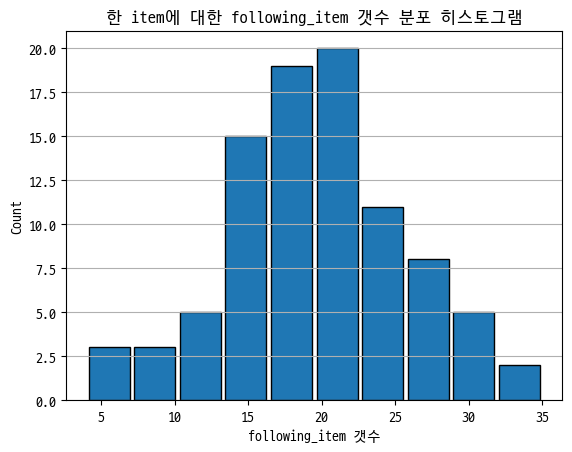

In [32]:
plot_histogram(input_var_col = df_pairs_mod_diff['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

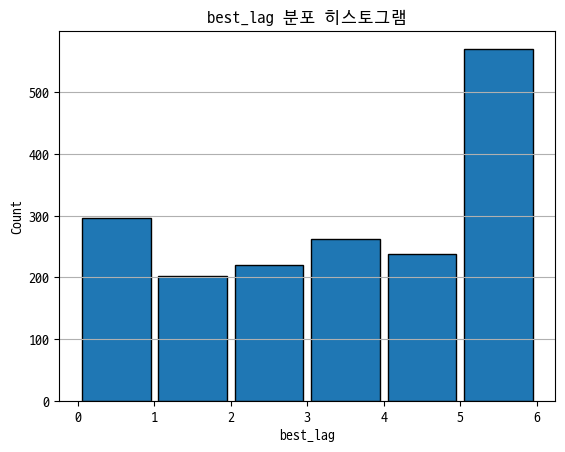

In [33]:
plot_histogram(input_var_col = pairs_mod_diff['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [34]:
import statsmodels.tsa.stattools as ts

# ---------------------------------------------------------------
#  1단계 (각 데이터가 불안정한지 ADF 검정)
# ---------------------------------------------------------------
# p-value가 0.05보다 크면 '불안정하다(단위근이 있다)'는 뜻
print(f"--- 1단계: ADF 검정 (불안정성 확인) ---")
dct_items_adf_ns = {} # filtered non-stationary items
dct_items_adf_s = {} # filtered stationary items
for i, item in enumerate(pivot.index):
    calc_p_val = ts.adfuller(pivot.loc[item])[1]
    if calc_p_val>0.05:
        dct_items_adf_ns[item] = float(calc_p_val)
        #print(f"{str(item)} 데이터 p-value: {calc_p_val:.4f}") # p-value > 0.05 (불안정)
        #print("-" * 40)
    else:
        dct_items_adf_s[item] = float(calc_p_val)
        #print(f"{str(item)} 데이터 p-value: {calc_p_val:.4f}") # p-value > 0.05 (불안정)
        #print("-" * 40)
    
print(f'Non-Stationary ({len(dct_items_adf_ns)}개 items): {dct_items_adf_ns}') # Co-integration candidate
print(f'Stationary: ({len(dct_items_adf_s)}개 items): {dct_items_adf_s}')

--- 1단계: ADF 검정 (불안정성 확인) ---


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Non-Stationary (22개 items): {'AANGBULD': 0.9894243389638399, 'ATLDMDBO': 0.09015018455087531, 'AXULOHBQ': 0.12483228858780177, 'DEWLVASR': 0.4066309984460655, 'DNMPSKTB': 0.06694244432401705, 'ELQGMQWE': 0.5796632646161022, 'EVBVXETX': 0.5026787470840136, 'FDXPMYGF': 0.19415742458957796, 'GYHKIVQT': 0.5820286118493817, 'HXYSSRXE': 0.6845220123708838, 'KJNSOAHR': 0.18326757326525778, 'LUENUFGA': 0.11496431273323404, 'OGAFEHLU': 0.07155197032381065, 'QVLMOEYE': 0.3570207443384179, 'RJCAXSGH': 0.975771249572837, 'RJGPVEXX': 0.11399148574516932, 'UIFPPCLR': 0.31526967079769136, 'VBYCLTYZ': 0.2512088712432241, 'WPQXWHYO': 0.3164867531446981, 'XIFHSOWQ': 0.17111521485938508, 'ZGJXVMNI': 0.8069737259832728, 'ZKENOUDA': 0.8611653905331763}
Stationary: (78개 items): {'AHMDUILJ': 8.311501923000167e-11, 'ANWUJOKX': 4.669152160421899e-05, 'APQGTRMF': 0.0002490891451913772, 'BEZYMBBT': 3.32041258890623e-06, 'BJALXPFS': 1.61689621586627e-07, 'BLANHGYY': 3.905882904779897e-05, 'BSRMSVTC': 4.2292938753

In [35]:
dct_items_adf_ns.keys()


dict_keys(['AANGBULD', 'ATLDMDBO', 'AXULOHBQ', 'DEWLVASR', 'DNMPSKTB', 'ELQGMQWE', 'EVBVXETX', 'FDXPMYGF', 'GYHKIVQT', 'HXYSSRXE', 'KJNSOAHR', 'LUENUFGA', 'OGAFEHLU', 'QVLMOEYE', 'RJCAXSGH', 'RJGPVEXX', 'UIFPPCLR', 'VBYCLTYZ', 'WPQXWHYO', 'XIFHSOWQ', 'ZGJXVMNI', 'ZKENOUDA'])

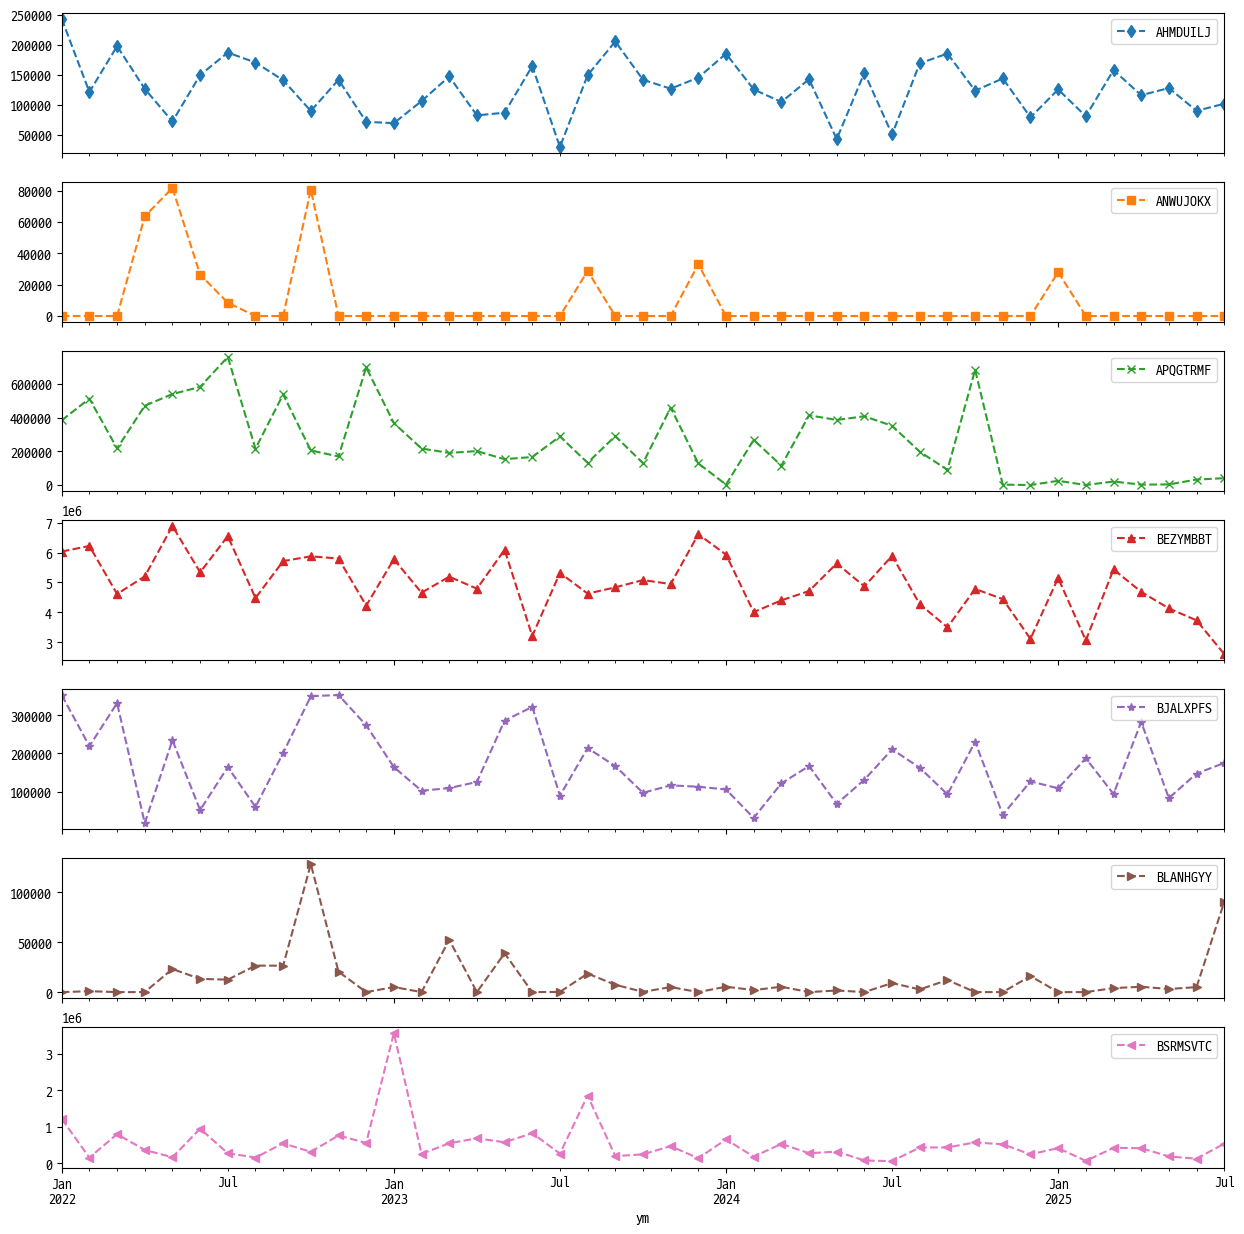

In [36]:
#####
##### Stationary 7 cases
#####

style = ['--d', '--s', '--x', '--^', '--*', '-->', '--<']
pivot.loc[list(dct_items_adf_s.keys())[:7]].T.plot(figsize=(15, 15), subplots=True, style=style)
#pivot.T.plot(figsize=(15, 15), subplots=True)
plt.show()

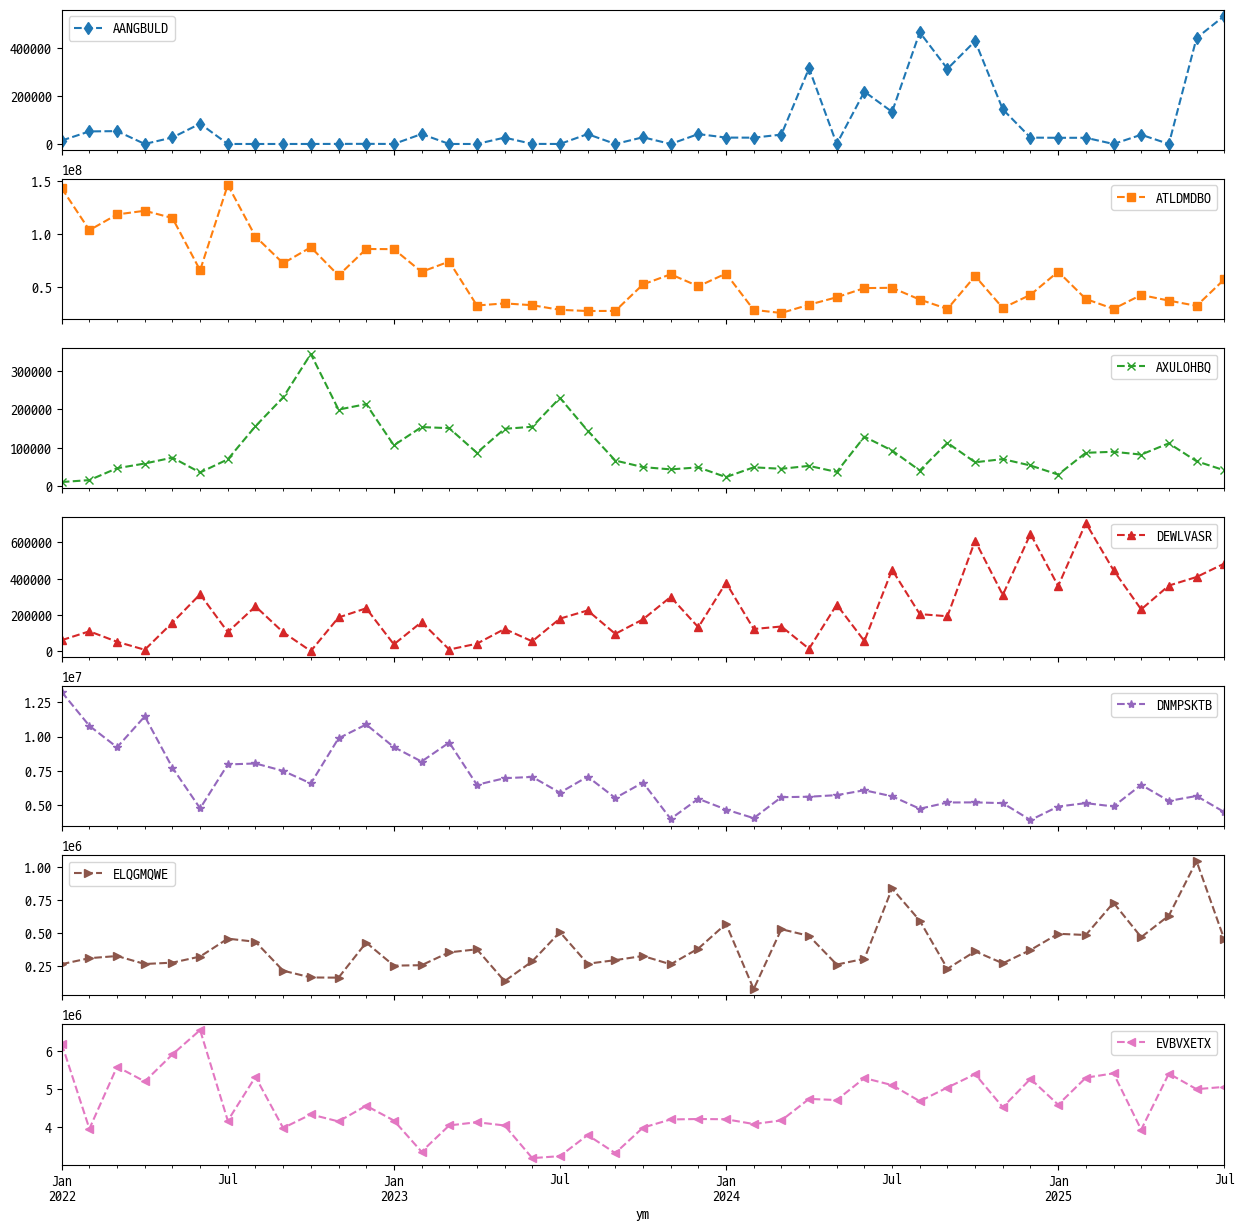

In [37]:
##### Non-Stationary 7 cases
#####

style = ['--d', '--s', '--x', '--^', '--*', '-->', '--<']
pivot.loc[list(dct_items_adf_ns.keys())[:7]].T.plot(figsize=(15, 15), subplots=True, style=style)
#pivot.T.plot(figsize=(15, 15), subplots=True)
plt.show()

In [38]:
pivot.loc[list(dct_items_adf_ns.keys())[:3]]

ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0
AXULOHBQ,11429.0,16365.0,47307.0,59524.0,74828.0,36182.0,70404.0,156481.0,231421.0,344263.0,...,62744.0,71046.0,54408.0,30708.0,87409.0,90027.0,82763.0,112061.0,65475.0,41989.0


In [39]:
pivot.loc[list(dct_items_adf_ns.keys())[:3]].apply(lambda x: np.diff(x), axis=1) # Series

item_id
AANGBULD    [38071.0, 1202.0, -53549.0, 26997.0, 57492.0, ...
ATLDMDBO    [-39528854.0, 14835414.0, 3470004.0, -6849124....
AXULOHBQ    [4936.0, 30942.0, 12217.0, 15304.0, -38646.0, ...
dtype: object

In [40]:
#pivot.loc[list(dct_items_adf_ns.keys())[:3]].apply(lambda x: np.diff(x), axis=1).to_frame()
ser_ns_diff = pivot.loc[list(dct_items_adf_ns.keys())].apply(lambda x: np.diff(x), axis=1)
pivot_ns_diff_m42 = pd.DataFrame([lst for lst in ser_ns_diff.values], index=ser_ns_diff.index, columns = pivot.columns[1:])
print(pivot_ns_diff_m42.shape)
pivot_ns_diff_m42

(22, 42)


ym,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,38071.0,1202.0,-53549.0,26997.0,57492.0,-84489.0,0.0,0.0,0.0,299.0,...,115649.0,-284477.0,-117741.0,-816.0,114.0,-25805.0,38441.0,-38441.0,441275.0,92203.0
ATLDMDBO,-39528854.0,14835414.0,3470004.0,-6849124.0,-49308542.0,80500743.0,-48663840.0,-25211551.0,15112740.0,-26627586.0,...,30984095.0,-30115852.0,12453530.0,21837285.0,-25783584.0,-9313021.0,13096031.0,-5313719.0,-4954922.0,24908437.0
AXULOHBQ,4936.0,30942.0,12217.0,15304.0,-38646.0,34222.0,86077.0,74940.0,112842.0,-144585.0,...,-50593.0,8302.0,-16638.0,-23700.0,56701.0,2618.0,-7264.0,29298.0,-46586.0,-23486.0
DEWLVASR,48881.0,-57951.0,-44012.0,150237.0,156024.0,-208520.0,141800.0,-142915.0,-103737.0,185367.0,...,417280.0,-299608.0,337028.0,-287893.0,348225.0,-261113.0,-216144.0,131691.0,47298.0,73900.0
DNMPSKTB,-2458313.0,-1557309.0,2244539.0,-3729677.0,-2956592.0,3192024.0,72725.0,-540498.0,-912038.0,3281184.0,...,7576.0,-55052.0,-1230972.0,985117.0,245176.0,-239379.0,1571404.0,-1170475.0,358314.0,-1168902.0
ELQGMQWE,44921.0,16251.0,-60033.0,9995.0,46044.0,135171.0,-23781.0,-218058.0,-51090.0,-1494.0,...,131180.0,-90106.0,100244.0,122375.0,-9097.0,243166.0,-259423.0,162424.0,411864.0,-589667.0
EVBVXETX,-2239454.0,1635188.0,-388453.0,713867.0,640453.0,-2388398.0,1155986.0,-1348456.0,358319.0,-185039.0,...,352374.0,-870872.0,747051.0,-679907.0,710375.0,114644.0,-1484052.0,1478209.0,-411124.0,60490.0
FDXPMYGF,-487.0,-84.0,35.0,2677.0,-2595.0,2911.0,-1794.0,-1234.0,58.0,64015.0,...,-560.0,468.0,10722.0,-11433.0,8406.0,-209.0,-8455.0,-247.0,2974.0,-1943.0
GYHKIVQT,-11343798.0,13622001.0,4438219.0,20786830.0,-22789253.0,17054413.0,1847623.0,-28286660.0,26718176.0,-15667122.0,...,-396266.0,-1352966.0,6922884.0,-696208.0,-6431055.0,4315772.0,-9231489.0,-7681847.0,7922848.0,9862318.0


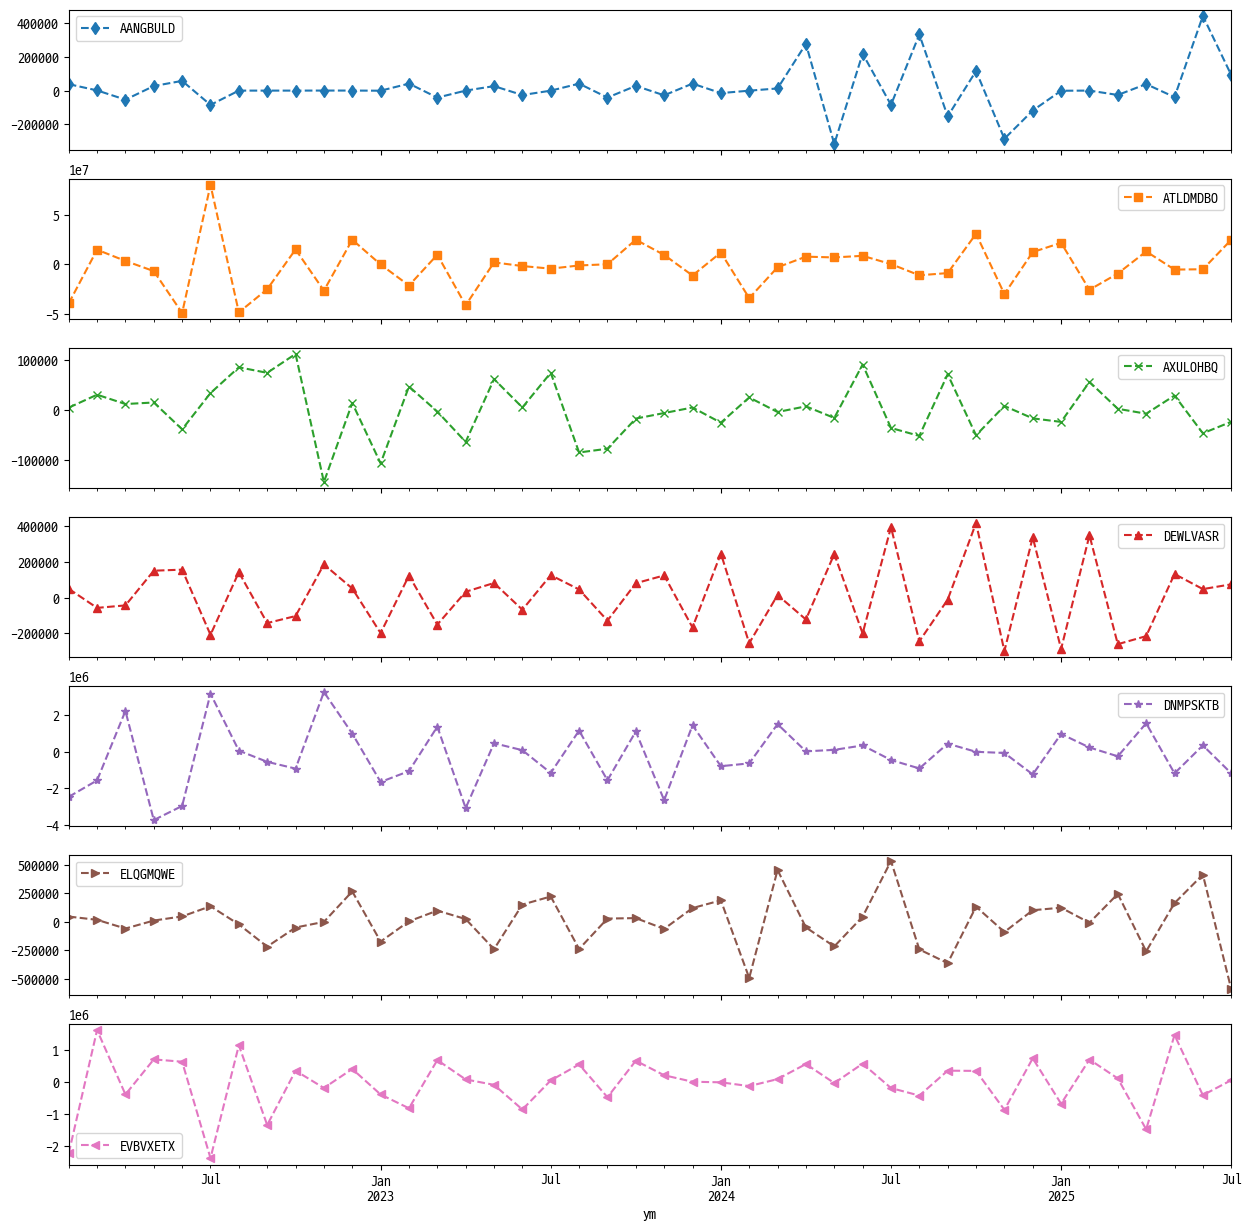

In [41]:
##### Non-Stationary 7 cases: x_diff case 
# ==> diff으로 인해 음수값이 나와 무역량 > 0에 맞지는 않지만,
#     여기 pair에 대해 우리가 현재 관심있는것은 상관관계 여부 & lag값 이므로, 
#     일단 max(x, 0)보정은 않하고 그대로 진행하기로 한다. 
#     => 상수 더하기·상수배 하기 같은 선형 변환은 상관계수를 바꾸지 않으므로 상관관계 계수값구하기에는 영향 미치지않을 것임
#####

style = ['--d', '--s', '--x', '--^', '--*', '-->', '--<']
pivot_ns_diff_m42.loc[list(dct_items_adf_ns.keys())[:7]].T.plot(figsize=(15, 15), subplots=True, style=style)
plt.show()

In [122]:
from statsmodels.tsa.stattools import adfuller, ccf

def adf_test(series, name):
    res = adfuller(series)
    print(f"[ADF] {name}: p-value = {res[1]:.4f}", end=" ")
    print("  => Stationary" if res[1] < 0.05 else "  => NOT Stationary\n")

adf_test(pivot_ns_diff_m42.iloc[0], pivot_ns_diff_m42.iloc[0].name)

[ADF] AANGBULD: p-value = 0.0001   => Stationary


In [116]:
pivot_ns_diff_m42.head()

ym,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,38071.0,1202.0,-53549.0,26997.0,57492.0,-84489.0,0.0,0.0,0.0,299.0,...,115649.0,-284477.0,-117741.0,-816.0,114.0,-25805.0,38441.0,-38441.0,441275.0,92203.0
ATLDMDBO,-39528854.0,14835414.0,3470004.0,-6849124.0,-49308542.0,80500743.0,-48663840.0,-25211551.0,15112740.0,-26627586.0,...,30984095.0,-30115852.0,12453530.0,21837285.0,-25783584.0,-9313021.0,13096031.0,-5313719.0,-4954922.0,24908437.0
AXULOHBQ,4936.0,30942.0,12217.0,15304.0,-38646.0,34222.0,86077.0,74940.0,112842.0,-144585.0,...,-50593.0,8302.0,-16638.0,-23700.0,56701.0,2618.0,-7264.0,29298.0,-46586.0,-23486.0
DEWLVASR,48881.0,-57951.0,-44012.0,150237.0,156024.0,-208520.0,141800.0,-142915.0,-103737.0,185367.0,...,417280.0,-299608.0,337028.0,-287893.0,348225.0,-261113.0,-216144.0,131691.0,47298.0,73900.0
DNMPSKTB,-2458313.0,-1557309.0,2244539.0,-3729677.0,-2956592.0,3192024.0,72725.0,-540498.0,-912038.0,3281184.0,...,7576.0,-55052.0,-1230972.0,985117.0,245176.0,-239379.0,1571404.0,-1170475.0,358314.0,-1168902.0


In [119]:
pivot_ns_diff_m42.iloc[i].name

'AANGBULD'

In [ ]:
##### x_diff 한 애들 ADF 재검사 (만약 재검사 통과 못하면, 한번 더 차분(x_diff) 또는 변환(ex: log변환)해서 최대한 정규분포 비슷하게)
for i in range(len(pivot_ns_diff_m42)):
    adf_test(pivot_ns_diff_m42.iloc[i], pivot_ns_diff_m42.iloc[i].name)
    #print(f'arima(p,d,q) = {use_ARIMA_chkD_or_Pred(pivot_ns_diff_m42, pivot_ns_diff_m42.iloc[i].name)}') # 


arima(p,d,q) = (1, 0, 1)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (0, 0, 0)
arima(p,d,q) = (1, 0, 1)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (2, 0, 1)
arima(p,d,q) = (2, 0, 2)
arima(p,d,q) = (2, 0, 0)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (0, 0, 0)
arima(p,d,q) = (0, 0, 0)
arima(p,d,q) = (0, 0, 0)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (2, 0, 2)
arima(p,d,q) = (1, 0, 0)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (2, 0, 0)
arima(p,d,q) = (0, 0, 1)
arima(p,d,q) = (1, 0, 1)


Text(0.5, 1.0, 'S-AANGBULD, after x_diff')

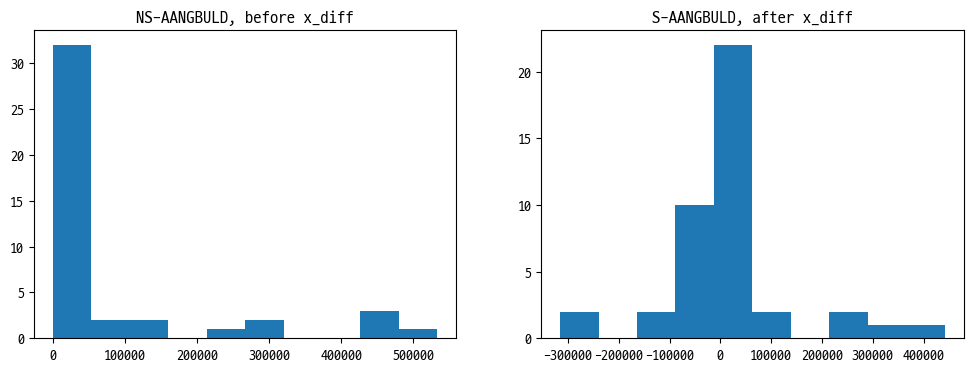

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(pivot.loc["AANGBULD"], bins=10)
ax1.set_title(f"NS-{pivot.loc["AANGBULD"].name}, before x_diff")
ax2.hist(pivot_ns_diff_m42.loc["AANGBULD"], bins=10)
ax2.set_title(f"S-{pivot.loc["AANGBULD"].name}, after x_diff")

In [45]:
# !pip install pmdarima -q # for auto_arima

In [ ]:
import pmdarima
print(pmdarima.__version__) # 2.1.1

2.1.1


In [103]:
from pmdarima import auto_arima



# =======================================================
# 1. 자동 ARIMA 모델 선택 (auto_arima)
#    ==> NS-var을 S-var로 변환에 필요한 차분값을 자동계산
# =======================================================
print("===== Auto ARIMA Model Selection (X = pivot.loc['AANGBULD']) =====")

auto_model_X = auto_arima(
    pivot.loc["AANGBULD"],
    seasonal=False,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    #ㄴscoring='rmse'
)

print("\n[Auto ARIMA X Model Summary]")
print(auto_model_X.summary()) # ARIMA(1,1,1)(0,0,0)[0] =< p, d, q

# Forecast
forecast_auto_X = auto_model_X.predict(n_periods=2)
print("\nAuto ARIMA Forecast (X, next 2 steps):")
print(forecast_auto_X)


===== Auto ARIMA Model Selection (X = pivot.loc['AANGBULD']) =====
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1109.227, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1111.698, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1107.280, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1109.763, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1110.094, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1106.032, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1106.208, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1106.723, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1104.951, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1107.267, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1110.398, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1103.586, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1108.299, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]         

In [97]:
# print(dir(auto_model_X.summary()), sep="; ")
# len(auto_model_X.summary().tables)#, auto_model_X.summary().tables[2]
# auto_model_X.summary().__dict__.keys() # dict_keys(['tables', 'extra_txt'])
# auto_model_X.summary().__dict__['tables'][0]

print(dir(auto_model_X), sep="; ")
#len(auto_model_X.summary().tables)#, auto_model_X.summary().tables[2]
#auto_model_X.summary().__dict__.keys() # dict_keys(['tables', 'extra_txt'])
#auto_model_X.summary().__dict__['tables'][0]
print(auto_model_X.get_params())
auto_model_X.get_params()['order'] # selected auto ARIMA model order

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_request_for_signature', '_check_exog', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_fit', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_params_html', '_html_repr', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_params', '_warn_for_older_version', 'aic', 'aicc', 'arima_res_', 'arparams', 'arroots', 'bic', 'bse', 'conf_int', 'df_model', 'df_resid', 'endog_index_', 'fit', 'fit_predict', 'fit_with_exog_', 'fittedvalues', 'get_metadata_rout

(1, 1, 1)

In [128]:
from pmdarima import auto_arima

def use_ARIMA_chkD_or_Pred(pivot:pd.DataFrame, item_id:str, 
                usage:str = 'check_d',  # 'check_d' or 'forecast'
                pred_steps:int = 1, 
                flg_trace = False,
                verbose:bool = False):
    if verbose:
        print("===== Auto ARIMA Model Selection (X = pivot.loc[item_id]) =====")
        flg_trace = True # 모델 실행 결과 화면출력(로그)
        
    auto_model_X = auto_arima(
        pivot.loc[item_id],
        seasonal=False,
        trace=flg_trace, #True,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True,
        #scoring='rmse', #NG
    )
    
    if usage == 'forecast': # Forecast
        forecast_auto_X = auto_model_X.predict(n_periods=pred_steps)
        if verbose: 
            print(f"Auto ARIMA Forecast (X, next {pred_steps} steps):")
            print(forecast_auto_X)
        return forecast_auto_X

    if verbose:
        print("\n[Auto ARIMA X Model Summary]")
        print(auto_model_X.summary()) # ARIMA(1,1,1)(0,0,0)[0] =< p, d, q
    return auto_model_X.get_params()['order']


print(use_ARIMA_chkD_or_Pred(pivot, "AANGBULD")) # 
print(use_ARIMA_chkD_or_Pred(pivot, "AANGBULD", usage='forecast', pred_steps=1)) # 


(1, 1, 1)
2025-08-01    595919.841375
Freq: MS, dtype: float64


In [127]:
##### x_diff 한 애들 ADF 재검사 (만약 재검사 통과 못하면, 한번 더 차분(x_diff) 또는 변환(ex: log변환)해서 최대한 정규분포 비슷하게)
for i in range(len(pivot_ns_diff_m42)):
    adf_test(pivot_ns_diff_m42.iloc[i], pivot_ns_diff_m42.iloc[i].name)
    print(f'arima(p,d,q) = {use_ARIMA_chkD_or_Pred(pivot_ns_diff_m42, pivot_ns_diff_m42.iloc[i].name)}') # 
    print(f'arima, d = {use_ARIMA_chkD_or_Pred(pivot_ns_diff_m42, pivot_ns_diff_m42.iloc[i].name)[1]}') # 


[ADF] AANGBULD: p-value = 0.0001   => Stationary
arima(p,d,q) = (1, 0, 1)
arima, d = 0
[ADF] ATLDMDBO: p-value = 0.0054   => Stationary
arima(p,d,q) = (0, 0, 1)
arima, d = 0
[ADF] AXULOHBQ: p-value = 0.0000   => Stationary
arima(p,d,q) = (0, 0, 0)
arima, d = 0
[ADF] DEWLVASR: p-value = 0.0011   => Stationary
arima(p,d,q) = (1, 0, 1)
arima, d = 0
[ADF] DNMPSKTB: p-value = 0.0000   => Stationary
arima(p,d,q) = (0, 0, 1)
arima, d = 0
[ADF] ELQGMQWE: p-value = 0.0000   => Stationary
arima(p,d,q) = (0, 0, 1)
arima, d = 0
[ADF] EVBVXETX: p-value = 0.0284   => Stationary
arima(p,d,q) = (2, 0, 1)
arima, d = 0
[ADF] FDXPMYGF: p-value = 0.0000   => Stationary
arima(p,d,q) = (2, 0, 2)
arima, d = 0
[ADF] GYHKIVQT: p-value = 0.0000   => Stationary
arima(p,d,q) = (2, 0, 0)
arima, d = 0
[ADF] HXYSSRXE: p-value = 0.0000   => Stationary
arima(p,d,q) = (0, 0, 1)
arima, d = 0
[ADF] KJNSOAHR: p-value = 0.0000   => Stationary
arima(p,d,q) = (0, 0, 1)
arima, d = 0
[ADF] LUENUFGA: p-value = 0.0000   => Stati

In [129]:
#####
##### B) Prophet model prediction
#####
from prophet import Prophet


#### model usage
def use_Prophet_forecast(pivot:pd.DataFrame, item_id:str, 
                pred_steps:int = 1, 
                pred_freq = 'M', # month freq
                #flg_trace = False,
                verbose:bool = False):
        
        
        
    # 1) dataframe preparation
    df = pd.DataFrame({
        'ds': pivot.loc[item_id].index,
        'y': pivot.loc[item_id].values
    })
    #print(df.index)
    df.set_index('ds').resample('MS')#.reset_index()
    #df['y'] = df['y'].replace(0.0, np.nan) # NaN을 Prophet이 처리하도록
    #print(df.index)
    
    # 2) Prophet 모델 생성
    model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False      
                    )
    model.fit(df)

    # 미래 1 month 예측
    future = model.make_future_dataframe(periods=pred_steps, freq = pred_freq)

    # 예측
    forecast = model.predict(future)
    
    return model, forecast



model, res = use_Prophet_forecast(pivot, "AANGBULD", pred_freq='MS', pred_steps=1)
display(res.tail(5)) # 
#print(use_Prophet_forecast(pivot, "AHMDUILJ", pred_freq='MS', pred_steps=1)) 

print("#####################\n\n pivot.shape: ", pivot.shape) # TRAIN(months=42) 2025-06-01 까지
pivot.head(3)


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
02:16:55 - cmdstanpy - INFO - Chain [1] start processing
02:16:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
39,2025-04-01,168043.511806,91056.564501,352215.740885,168043.511806,168043.511806,52287.515080,52287.515080,52287.515080,52287.515080,52287.515080,52287.515080,0.0,0.0,0.0,220331.026885
40,2025-05-01,173577.084824,-48798.303096,200341.841394,173577.084824,173577.084824,-97059.174971,-97059.174971,-97059.174971,-97059.174971,-97059.174971,-97059.174971,0.0,0.0,0.0,76517.909853
41,2025-06-01,179295.110277,153924.819323,409673.295080,179295.110277,179295.110277,110968.730002,110968.730002,110968.730002,110968.730002,110968.730002,110968.730002,0.0,0.0,0.0,290263.840279
42,2025-07-01,184828.683295,123950.798812,382455.282249,184828.683295,184828.683295,72440.402755,72440.402755,72440.402755,72440.402755,72440.402755,72440.402755,0.0,0.0,0.0,257269.086050
43,2025-08-01,190546.708748,207925.576343,459041.301822,190546.708682,190546.708818,137528.094699,137528.094699,137528.094699,137528.094699,137528.094699,137528.094699,0.0,0.0,0.0,328074.803447


#####################

 pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
#res.columns, 
res['yhat'].values[-1] # test target 025-07-01 pred. 값

np.float64(328074.8034468123)

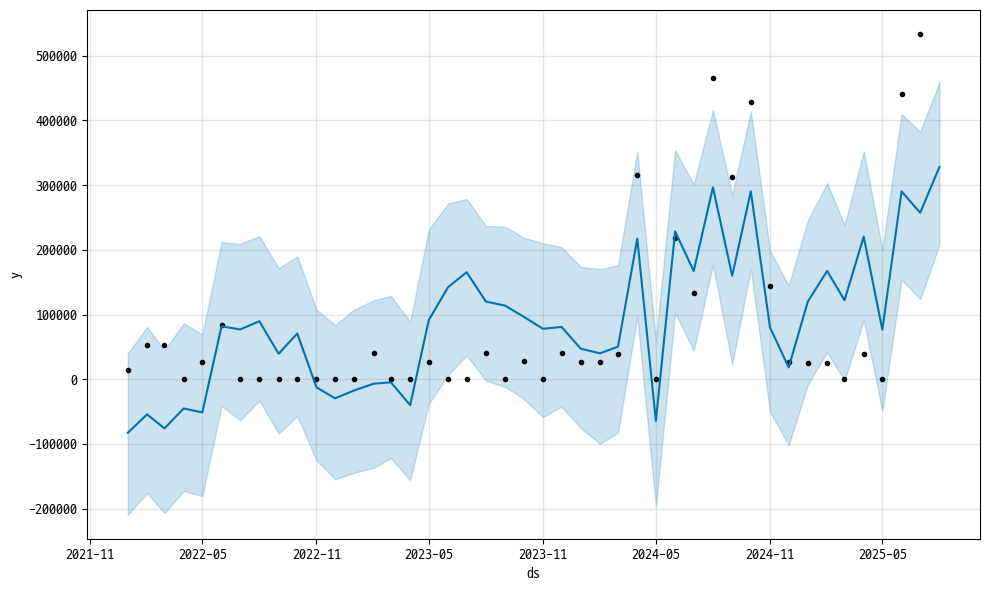

In [131]:
model.plot(res)
plt.show()

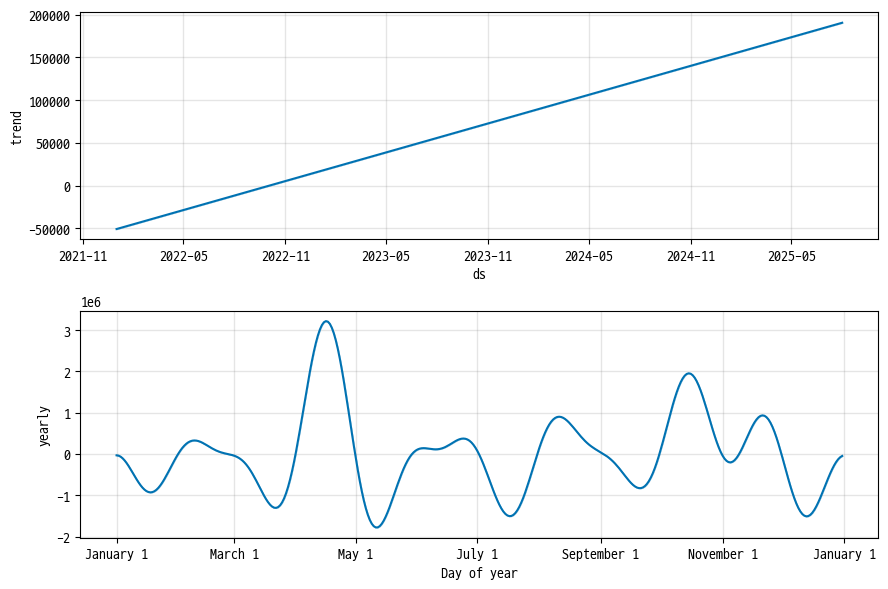

In [132]:
# 예측된 트렌드, 계절성 등을 시각화
model.plot_components(res)
plt.show()

In [133]:
#####
##### B) Prophet model prediction
#####
from prophet import Prophet


#### model usage
def use_Prophet_forecast(pivot:pd.DataFrame, item_id:str, 
                pred_steps:int = 1, 
                pred_freq = 'M', # month freq
                #flg_trace = False,
                verbose:bool = False):
        
        
        
    # 1) dataframe preparation
    df = pd.DataFrame({
        'ds': pivot.loc[item_id].index,
        'y': pivot.loc[item_id].values
    })
    #print(df.index)
    df.set_index('ds').resample('MS')#.reset_index()
    df['y'] = df['y'].replace(0.0, np.nan) # NaN을 Prophet이 처리하도록
    #print(df.index)
    
    # 2) Prophet 모델 생성
    model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False      
                    )
    model.fit(df)

    # 미래 1 month 예측
    future = model.make_future_dataframe(periods=pred_steps, freq = pred_freq)

    # 예측
    forecast = model.predict(future)
    
    return model, forecast



model, res = use_Prophet_forecast(pivot, "AANGBULD", pred_freq='MS', pred_steps=1)
display(res.tail(5)) # 
#print(use_Prophet_forecast(pivot, "AHMDUILJ", pred_freq='MS', pred_steps=1)) 

print("#####################\n\n pivot.shape: ", pivot.shape) # TRAIN(months=42) 2025-06-01 까지
pivot.head(3)


02:19:21 - cmdstanpy - INFO - Chain [1] start processing
02:19:21 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
39,2025-04-01,165590.755987,31234.049102,160128.397094,165590.755987,165590.755987,-69116.607272,-69116.607272,-69116.607272,-69116.607272,-69116.607272,-69116.607272,0.0,0.0,0.0,96474.148715
40,2025-05-01,168678.463462,47150.082529,176540.385389,168678.463462,168678.463462,-56207.887767,-56207.887767,-56207.887767,-56207.887767,-56207.887767,-56207.887767,0.0,0.0,0.0,112470.575694
41,2025-06-01,171869.094519,217318.996548,345963.172280,171869.094519,171869.094519,108288.815874,108288.815874,108288.815874,108288.815874,108288.815874,108288.815874,0.0,0.0,0.0,280157.910393
42,2025-07-01,174956.801993,440475.098847,573570.836369,174956.801993,174956.801993,333953.735945,333953.735945,333953.735945,333953.735945,333953.735945,333953.735945,0.0,0.0,0.0,508910.537938
43,2025-08-01,178147.433050,313896.810018,449299.218044,178147.404421,178147.465553,202357.224723,202357.224723,202357.224723,202357.224723,202357.224723,202357.224723,0.0,0.0,0.0,380504.657773


#####################

 pivot.shape:  (100, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0


prediction of 2025-07-01 = 380504.6577729067


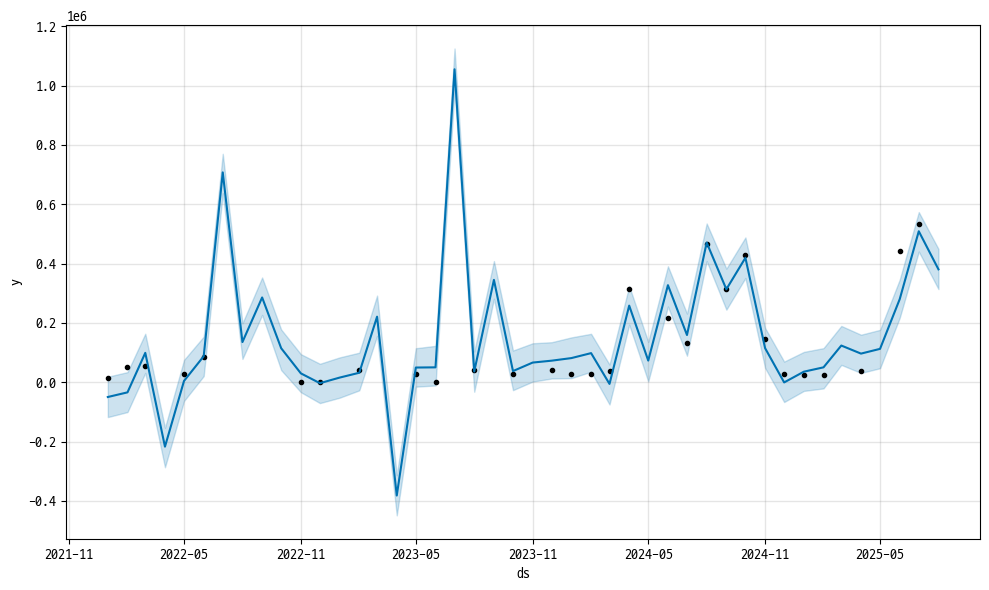

In [134]:
#res.columns, 
print(f'prediction of 2025-07-01 = {res['yhat'].values[-1]}') # test target 025-07-01 pred. 값
model.plot(res)
plt.show()

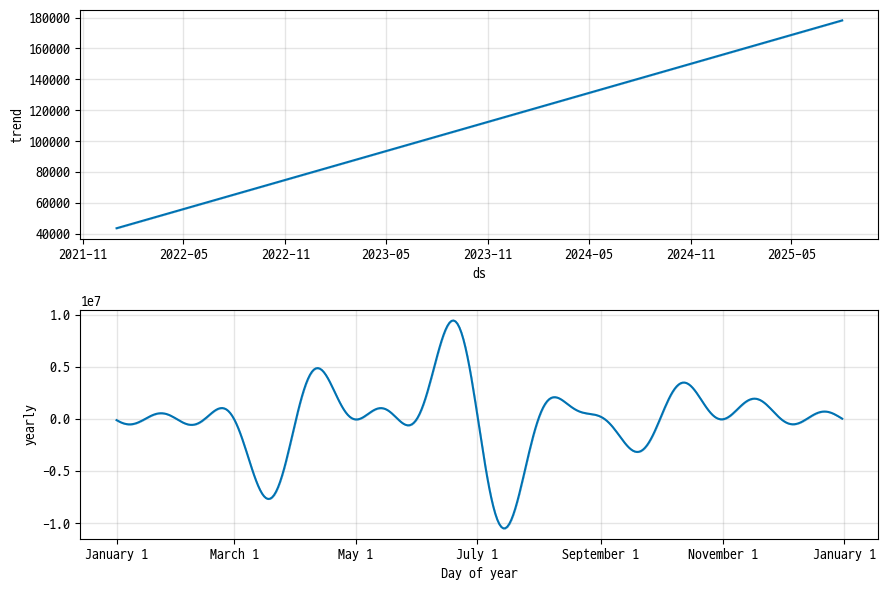

In [135]:
# 예측된 트렌드, 계절성 등을 시각화
model.plot_components(res)
plt.show()

In [47]:
#####
##### [ pairs와  pairs_diff 비교 ] => 서로의 교집합, 차집합 비교 
#####


In [48]:
print(dct_pair_detection['comv_no'].intersection(dct_pair_diff_detection['comv_no']), sep="\t")
print(dct_pair_detection['comv_no'] - dct_pair_diff_detection['comv_no'])
print(dct_pair_diff_detection['comv_no'] - dct_pair_detection['comv_no'])
print(dct_pair_detection['comv_no']== dct_pair_diff_detection['comv_no'])

{'KFQSHBNH', 'PLMZALFA', 'GMBFCMIU', 'QSDCUCLB', 'RUVXNNVA', 'TANNMIMB', 'ANWUJOKX', 'RJCAXSGH', 'GIKPEWTY'}
set()
set()
True


In [49]:
dct_pair_detection['comv_no'].intersection(set(dct_items_adf_ns.keys()))

# {'RJCAXSGH'} ==> 이게  comovement 찾는데 포함되려면 min_non_zero = 12 -> 7로 변경해야함.

{'RJCAXSGH'}

array([<Axes: xlabel='ym'>], dtype=object)

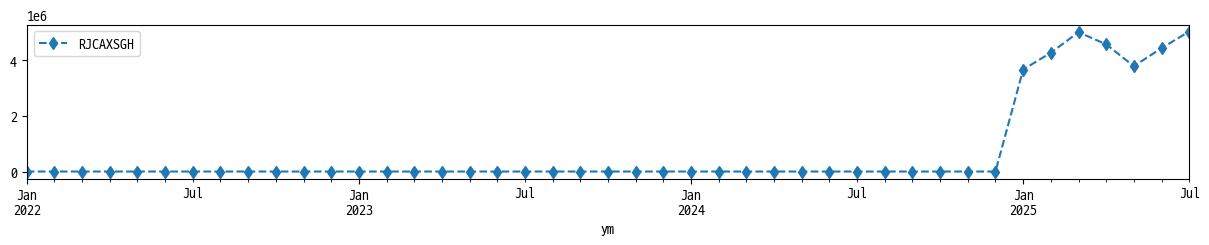

In [50]:
pivot.loc[list({'RJCAXSGH'})].T.plot(figsize=(15, 2), subplots=True, style=style)

In [51]:
#####
##### [ pairs와  pairs_diff 비교 ] => 서로의 교집합, 차집합 비교 
#####

print(pairs.shape, pairs_diff.shape)
display(pairs.head(3))
pairs[['leading_item_id','following_item_id']].iloc[:2]
list_of_tuples = list(pairs[['leading_item_id','following_item_id']].iloc[:2].itertuples(index=False)) 
print(list_of_tuples) 


(1425, 4) (1562, 4)


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,APQGTRMF,5,-0.443984
1,AANGBULD,DEWLVASR,6,0.640221
2,AANGBULD,DNMPSKTB,4,-0.410635


[Pandas(leading_item_id='AANGBULD', following_item_id='APQGTRMF'), Pandas(leading_item_id='AANGBULD', following_item_id='DEWLVASR')]


In [52]:
#list(pairs[['leading_item_id','following_item_id']].to_records(index=False))
print(len(set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)))) # 1425개 (1425 - 634 = 791 )
print(len(set(pairs_diff[['leading_item_id','following_item_id']].itertuples(index=False)))) # 1562개 (1562 - 634 = 928)

1425
1562


In [53]:
len(set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).intersection(
    set(pairs_diff[['leading_item_id','following_item_id']].itertuples(index=False)) ) ) # 634 개만 공통

#### 여기서 NS items가 공통부분에 들어가는지 여부 확인필요 
# <====== NS items 22개중 21 개가 634에 포함되어 있음 ({'RJCAXSGH'}가 안들어가 있는 item이고, 이건 원체 pair에 들어가 있지도 않음 by non-zero < 12 조건때문에)

# 공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']


634

In [54]:
common_pair_n634 = [tuple(x) for x in set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).intersection(
    set(pairs_diff[['leading_item_id','following_item_id']].itertuples(index=False)))]
not_common_pair_n791 = [tuple(x) for x in set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).difference(
    set(pairs_diff[['leading_item_id','following_item_id']].itertuples(index=False)))]
len(common_pair_n634), len(not_common_pair_n791), set(common_pair_n634).intersection(set(not_common_pair_n791))

(634, 791, set())

In [55]:
#####
##### [ pairs와  pairs_diff의 공통부분에 들어가는 items와  Non-Stationary Items간 집합 비교 
#####

#print(*dir(set), sep=",")
len(dct_items_adf_ns)

22

In [56]:
lst_in_common_pair_n634 = set()
lst_not_in_common_pair_n634 = set()
for item in dct_items_adf_ns:
    for tup_pair in common_pair_n634:
        if item in tup_pair: 
            #print(f"{item} in common pairs")
            lst_in_common_pair_n634.add(item)
            continue
        else:
            for tup_pair2 in not_common_pair_n791:
                if item in tup_pair2:
                    #lst_not_in_common_pair_n634.add(item)
                    #print(f"{item} is in not_common_pair_n791")
                    continue
                    

                    
            
            
len(lst_in_common_pair_n634), lst_in_common_pair_n634, #len(lst_not_in_common_pair_n634), lst_not_in_common_pair_n634

(21,
 {'AANGBULD',
  'ATLDMDBO',
  'AXULOHBQ',
  'DEWLVASR',
  'DNMPSKTB',
  'ELQGMQWE',
  'EVBVXETX',
  'FDXPMYGF',
  'GYHKIVQT',
  'HXYSSRXE',
  'KJNSOAHR',
  'LUENUFGA',
  'OGAFEHLU',
  'QVLMOEYE',
  'RJGPVEXX',
  'UIFPPCLR',
  'VBYCLTYZ',
  'WPQXWHYO',
  'XIFHSOWQ',
  'ZGJXVMNI',
  'ZKENOUDA'})

In [57]:
print(type(dct_items_adf_ns.keys()), type(lst_in_common_pair_n634))
set(dct_items_adf_ns.keys()) - lst_in_common_pair_n634

<class 'dict_keys'> <class 'set'>


{'RJCAXSGH'}

In [58]:
pivot_NS = pivot.loc[list(dct_items_adf_ns.keys())]
print(pivot_NS.shape)
pivot_NS.head(3)

(22, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0
AXULOHBQ,11429.0,16365.0,47307.0,59524.0,74828.0,36182.0,70404.0,156481.0,231421.0,344263.0,...,62744.0,71046.0,54408.0,30708.0,87409.0,90027.0,82763.0,112061.0,65475.0,41989.0


In [59]:
#pivot.loc[list(dct_items_adf_ns.keys())[:3]].apply(lambda x: np.diff(x), axis=1).to_frame()
ser_ns_diff = pivot.loc[list(dct_items_adf_ns.keys())].apply(lambda x: np.diff(x), axis=1)
pivot_ns_diff_m42 = pd.DataFrame([lst for lst in ser_ns_diff.values], index=ser_ns_diff.index, columns = pivot.columns[1:])
print(pivot_ns_diff_m42.shape)
pivot_ns_diff_m42.head(3)


(22, 42)


ym,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,38071.0,1202.0,-53549.0,26997.0,57492.0,-84489.0,0.0,0.0,0.0,299.0,...,115649.0,-284477.0,-117741.0,-816.0,114.0,-25805.0,38441.0,-38441.0,441275.0,92203.0
ATLDMDBO,-39528854.0,14835414.0,3470004.0,-6849124.0,-49308542.0,80500743.0,-48663840.0,-25211551.0,15112740.0,-26627586.0,...,30984095.0,-30115852.0,12453530.0,21837285.0,-25783584.0,-9313021.0,13096031.0,-5313719.0,-4954922.0,24908437.0
AXULOHBQ,4936.0,30942.0,12217.0,15304.0,-38646.0,34222.0,86077.0,74940.0,112842.0,-144585.0,...,-50593.0,8302.0,-16638.0,-23700.0,56701.0,2618.0,-7264.0,29298.0,-46586.0,-23486.0


In [60]:
pivot_s_m42  = pivot.loc[list(dct_items_adf_s.keys())].drop(["2022-01-01"], axis=1)
print(pivot_s_m42.shape)
pivot_s_m42.head(3)

(78, 42)


ym,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AHMDUILJ,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,141264.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,0.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,169440.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0


In [61]:
#####
##### 2단계 : 이제 NS(n=22)는 차분(=1)으로 S로 변환하고, 원래 S(n=78) 을 다 포함하여 상관관계를 구하자.
##### 

lst_items_adf_ns = list(dct_items_adf_ns.keys())
lst_items_adf_s= list(dct_items_adf_s.keys())

ser_ns_diff = pivot.loc[list(dct_items_adf_ns.keys())].apply(lambda x: np.diff(x), axis=1)
pivot_ns_diff_m42 = pd.DataFrame([lst for lst in ser_ns_diff.values], index=ser_ns_diff.index, columns = pivot.columns[1:])
pivot_s_m42  = pivot.loc[list(dct_items_adf_s.keys())].drop(["2022-01-01"], axis=1)
# 여기서 pivot은 pivot_s_m42 +pivot_ns_diff_m42의 모든 items이름 얻기 위함

def find_comovement_pairs_diff_ns(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    #months = pivot.columns.to_list()
    months = pivot_s_m42.columns.to_list()
    
    n_months = len(months)
    print(f'n_months = {n_months}')
    
    results = []

    for i, leader in tqdm(enumerate(items)):
        ##x = pivot.loc[leader].values.astype(float)
        #x_raw = pivot.loc[leader].values.astype(float)
        if leader in lst_items_adf_ns:
            x = pivot_ns_diff_m42.loc[leader].values.astype(float) # 변화량, 1차분 (42months)
        elif leader in lst_items_adf_s:
            x = pivot_s_m42.loc[leader].values.astype(float) # level (42months)
        else:
            print(f"{leader} not in pivot.index ==> ERROR!!!" )
            
        if np.count_nonzero(x) < min_nonzero:
            continue

        #x = np.diff(x_raw) # 변화량, 1차분
        for follower in items:
            if follower == leader:
                continue

            ##y = pivot.loc[follower].values.astype(float)
            #y_raw = pivot.loc[follower].values.astype(float)
            if follower in lst_items_adf_ns:
                y = pivot_ns_diff_m42.loc[follower].values.astype(float) # 변화량, 1차분 (42months)
            elif follower in lst_items_adf_s:
                y = pivot_s_m42.loc[follower].values.astype(float) # level (42months)
            else:
                print(f"{follower} not in pivot.index ==> ERROR!!!" )           
            
            if np.count_nonzero(y) < min_nonzero:
                continue
            
            #y = np.diff(y_raw) # 변화량, 1차분
            best_lag = None
            best_corr = 0.0

            # lag = 1 ~ max_lag 탐색
            for lag in range(1, max_lag + 1):
                if (n_months-1) <= lag: # diff로 데이터 1개 줄어서 n_months-1 (43 -> 42)
                    continue
                
                # x_diff[:-lag], y_diff[lag:] 비교
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            # 임계값 이상이면 공행성쌍으로 채택
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    pairs = pd.DataFrame(results)
    return pairs

pairs_diff_ns = find_comovement_pairs_diff_ns(pivot)
print("탐색된 공행성쌍 수:", len(pairs_diff_ns)) 
pairs_diff_ns.head()

n_months = 42


100it [00:07, 12.95it/s]

탐색된 공행성쌍 수: 1014


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,DEWLVASR,6,0.483517
1,AANGBULD,FTSVTTSR,3,0.437522
2,AANGBULD,GKQIJYDH,5,-0.433616
3,AANGBULD,LTOYKIML,1,0.449866
4,AANGBULD,NAQIHUKZ,2,0.464581


In [62]:
df_pairs_diff_ns = pairs_diff_ns.groupby('leading_item_id')['following_item_id'] \
    .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
df_pairs_diff_ns    

###
### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
###

dct_pair_diff_ns_detection = {'comv_yes':df_pairs_diff_ns.index.to_list() , 
                      'comv_no': set(train['item_id']).difference(set(df_pairs_diff_ns.index.to_list()))}
print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_diff_ns_detection['comv_no']))
print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_diff_ns_detection['comv_no']))

print("공행성 탐지된 상품수: ", len(dct_pair_diff_ns_detection['comv_yes']))
print("공행성이 탐지된 상품id: ", sorted(dct_pair_diff_ns_detection['comv_yes'])) 

공행성이 탐지되지 않은 상품수:  9
공행성이 탐지되지 않은 상품id:  ['ANWUJOKX', 'GIKPEWTY', 'GMBFCMIU', 'KFQSHBNH', 'PLMZALFA', 'QSDCUCLB', 'RJCAXSGH', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  91
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

In [63]:
print(df_pairs_diff_ns.sum())
df_pairs_diff

size    1014
dtype: int64


,size
leading_item_id,
BSRMSVTC,31
EVBVXETX,30
XIIEJNEE,30
ROACSLMG,28
OGAFEHLU,27
...,...
VUAFAIYJ,8
VWMBASNE,7
DBWLZWNK,6


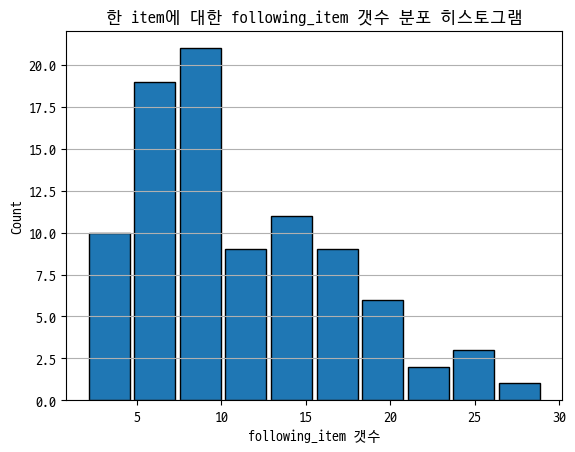

In [64]:
plot_histogram(input_var_col = df_pairs_diff_ns['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

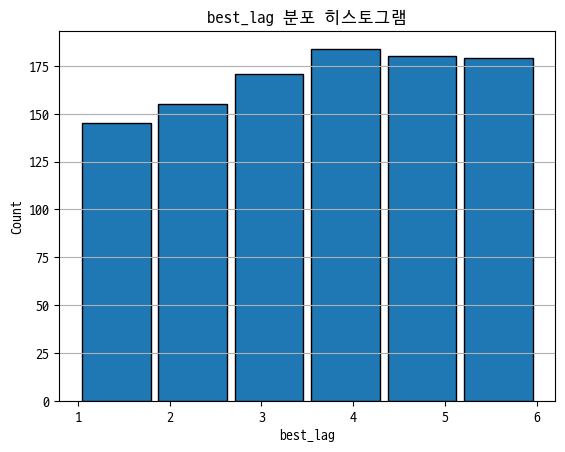

In [65]:
plot_histogram(input_var_col = pairs_diff_ns['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [68]:
pairs_diff_ns = find_comovement_pairs_diff_ns(pivot, max_lag=9, min_nonzero=7, corr_threshold=0.4)
print("탐색된 공행성쌍 수:", len(pairs_diff_ns)) 
pairs_diff_ns.head()

n_months = 42


100it [00:11,  8.35it/s]

탐색된 공행성쌍 수: 1693


,leading_item_id,following_item_id,best_lag,max_corr
0,AANGBULD,DEWLVASR,6,0.483517
1,AANGBULD,FTSVTTSR,3,0.437522
2,AANGBULD,GKQIJYDH,5,-0.433616
3,AANGBULD,KAGJCHMR,7,0.474824
4,AANGBULD,LLHREMKS,9,0.404825


In [70]:
def comov_pair_summary(pairs_diff_ns):
    df_pairs_diff_ns = pairs_diff_ns.groupby('leading_item_id')['following_item_id'] \
        .aggregate(["size"]).sort_values(by='size', ascending=False) # or 'count'
    df_pairs_diff_ns    

    ###
    ### ==> 따라서 100개 아이템중 9개는 공행성쌍이 탐지 되지않았다. ==> 공행성쌍이 탐지 vs. 공행성쌍이 탐지 실패 아이템으로 cat. 가능 => 쓸모는 없다. 공행성쌍에 포함되지않으면 어차피 학습데이터로 들어가지않는다.
    ###

    dct_pair_diff_ns_detection = {'comv_yes':df_pairs_diff_ns.index.to_list() , 
                        'comv_no': set(train['item_id']).difference(set(df_pairs_diff_ns.index.to_list()))}
    print("공행성이 탐지되지 않은 상품수: ", len(dct_pair_diff_ns_detection['comv_no']))
    print("공행성이 탐지되지 않은 상품id: ", sorted(dct_pair_diff_ns_detection['comv_no']))

    print("공행성 탐지된 상품수: ", len(dct_pair_diff_ns_detection['comv_yes']))
    print("공행성이 탐지된 상품id: ", sorted(dct_pair_diff_ns_detection['comv_yes'])) 
    
comov_pair_summary(pairs_diff_ns)

공행성이 탐지되지 않은 상품수:  5
공행성이 탐지되지 않은 상품id:  ['GIKPEWTY', 'GMBFCMIU', 'PLMZALFA', 'RUVXNNVA', 'TANNMIMB']
공행성 탐지된 상품수:  95
공행성이 탐지된 상품id:  ['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC', 'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU', 'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE', 'EVBVXETX', 'FCYBOAXC', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI', 'FTSVTTSR', 'FWUCPMMW', 'GKQIJYDH', 'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY', 'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO', 'KFQSHBNH', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM', 'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV', 'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS', 'OXKURKXR', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB', 'QRKRBYJL', 'QSDCUCLB', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM', 'RJCAXSGH', 'RJGPVEXX', 'ROACSLMG', 'SAAYMURU', 'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', 'STZDBITS', 'SUOYXCHP', 

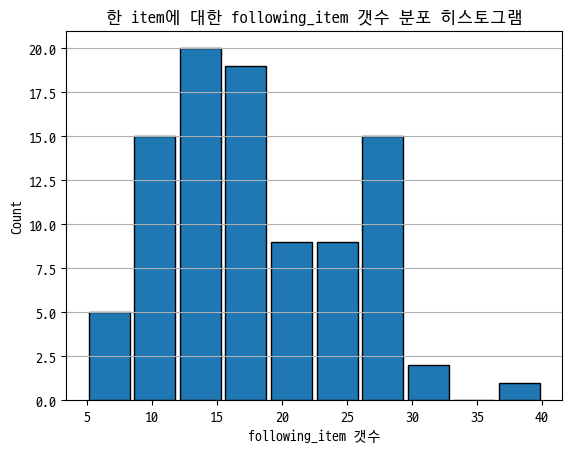

In [71]:
plot_histogram(input_var_col = df_pairs_diff_ns['size'] , num_bin = 10,
                title_str = "한 item에 대한 following_item 갯수 분포 히스토그램",
                xlbl_str = 'following_item 갯수',
                verbose = False)

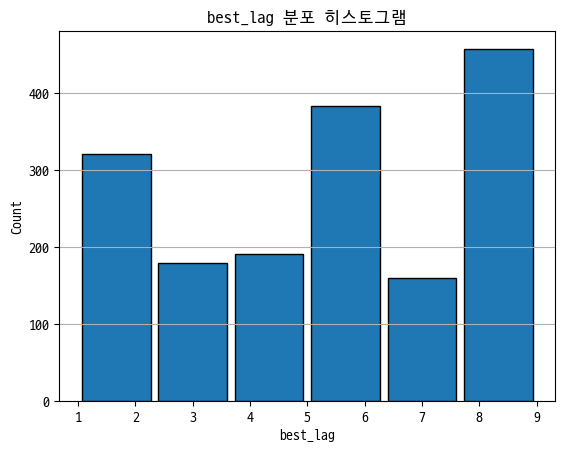

In [72]:
plot_histogram(input_var_col = pairs_diff_ns['best_lag'] , num_bin = 6,
                title_str = "best_lag 분포 히스토그램",
                xlbl_str = 'best_lag',
                verbose = False)

In [ ]:
len(set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).intersection(
    set(pairs_diff_ns[['leading_item_id','following_item_id']].itertuples(index=False)) ) ) # 817 개만 공통

817

In [74]:
common_pair = [tuple(x) for x in set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).intersection(
    set(pairs_diff_ns[['leading_item_id','following_item_id']].itertuples(index=False)))]
not_common_pair = [tuple(x) for x in set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).difference(
    set(pairs_diff_ns[['leading_item_id','following_item_id']].itertuples(index=False)))]
len(common_pair), len(not_common_pair), set(common_pair).intersection(set(not_common_pair))

(817, 608, set())

In [ ]:
def chk_ns_vs_common_pair(pairs, pairs_diff_ns):
    common_pair = [tuple(x) for x in set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).intersection(
    set(pairs_diff_ns[['leading_item_id','following_item_id']].itertuples(index=False)))]
    not_common_pair = [tuple(x) for x in set(pairs[['leading_item_id','following_item_id']].itertuples(index=False)).difference(
    set(pairs_diff_ns[['leading_item_id','following_item_id']].itertuples(index=False)))]
    return common_pair, not_common_pair



In [75]:
lst_in_common_pair = set()
lst_not_in_common_pair = set()
for item in dct_items_adf_ns:
    for tup_pair in common_pair:
        if item in tup_pair: 
            #print(f"{item} in common pairs")
            lst_in_common_pair.add(item)
            continue
        else:
            for tup_pair2 in not_common_pair:
                if item in tup_pair2:
                    #lst_not_in_common_pair_n634.add(item)
                    #print(f"{item} is in not_common_pair_n791")
                    continue
                    

                    
            
            
len(lst_in_common_pair), lst_in_common_pair

(21,
 {'AANGBULD',
  'ATLDMDBO',
  'AXULOHBQ',
  'DEWLVASR',
  'DNMPSKTB',
  'ELQGMQWE',
  'EVBVXETX',
  'FDXPMYGF',
  'GYHKIVQT',
  'HXYSSRXE',
  'KJNSOAHR',
  'LUENUFGA',
  'OGAFEHLU',
  'QVLMOEYE',
  'RJGPVEXX',
  'UIFPPCLR',
  'VBYCLTYZ',
  'WPQXWHYO',
  'XIFHSOWQ',
  'ZGJXVMNI',
  'ZKENOUDA'})

In [ ]:
################## ==> 이건 일단 안해도 될것 같음 (find_comovement_pairs_diff_ns() 에서 이걸 고려하여 상관관계구했음)
# # =======================================================
# # 3 단계 : Granger Causality Test
# # "X가 Y를 예측하는 데 도움이 되는가?"
# # "Y가 X를 예측하는 데 도움이 되는가?"
# # 를 통계적으로 검정하는 공식적인 방법.
# # =======================================================
# print("===== Granger Causality Test: Does X → Y? =====")
# grangercausalitytests(df[["Y", "X"]], maxlag=5, verbose=True)

# print("\n===== Granger Causality Test: Does Y → X? =====")
# grangercausalitytests(df[["X", "Y"]], maxlag=5, verbose=True)


In [ ]:
# ---------------------------------------------------------------
#  4단계 (엥글-그레인저 공행성 검정) ==> 이건 NS인 변수들간에 테스트해주어야 할것임.
#
# statsmodels의 'coint' 함수가 2단계를 한방에 처리해줌!
# ---------------------------------------------------------------

print(f"--- 2단계: 공행성 검정 (coint) ---")


# 테스트 1: x와 y (공행성 관계가 있도록 만든 쌍)
score, pvalue_xy, _ = ts.coint(x, y)

print(f"X와 Y의 공행성 검정:")
print(f"  검정 통계량: {score:.4f}")
print(f"  p-value: {pvalue_xy:.4f}") # <- 이 값을 확인!

if pvalue_xy < 0.05:
    print("  결과: p-value가 0.05보다 작으므로, 공행성 관계에 있다! (귀무가설 기각)")
else:
    print("  결과: p-value가 0.05보다 크므로, 공행성 관계가 아니다. (귀무가설 채택)")

print("-" * 20)



(22, 43)


ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,299.0,574.0,0.0,41353.0,0.0,0.0,26524.0,340.0,0.0,41142.0,0.0,27888.0,0.0,41311.0,26645.0,26237.0,39044.0,315325.0,0.0,218073.0,133775.0,465327.0,313076.0,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,60826581.0,85808405.0,85682937.0,64245780.0,73995179.0,32508848.0,34518439.0,32799720.0,28442820.0,27316997.0,27425218.0,52409481.0,61962358.0,50663797.0,62651583.0,28414592.0,25450412.0,33267911.0,40284313.0,48941975.0,49214001.0,38132473.0,29291955.0,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0
AXULOHBQ,11429.0,16365.0,47307.0,59524.0,74828.0,36182.0,70404.0,156481.0,231421.0,344263.0,199678.0,213933.0,106855.0,154294.0,151397.0,87390.0,149718.0,155034.0,230097.0,144916.0,67272.0,50193.0,44299.0,49510.0,24220.0,49675.0,45821.0,53394.0,37613.0,129213.0,93286.0,41377.0,113337.0,62744.0,71046.0,54408.0,30708.0,87409.0,90027.0,82763.0,112061.0,65475.0,41989.0


In [173]:
from statsmodels.tsa.api import VAR


def fit_var(df, maxlags=6):
    model = VAR(df)
    #results = model.fit(maxlags=maxlags, ic='aic')
    results = model.fit(maxlags=maxlags, ic=None)
    print(f"Selected lag order: {results.k_ar}")
    return results


#res = fit_var(pivot.T)
#res = fit_var(pivot.T.iloc[:,[0, 1, 3]], maxlags=6)
#res = fit_var(pivot_NS.T.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]], maxlags=6)
res = fit_var(pivot_NS.T, maxlags=6)

Selected lag order: 6


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [174]:
print(res.coefs.shape) #(6, 100, 100)
print(*[item for item in dir(res) if not item.startswith("_")])
#    print(item)
#res.summary()



(6, 22, 22)
acf acorr aic bic bse coefs coefs_exog cov_params cov_ybar dates detomega df_model df_resid endog endog_lagged exog exog_names fevd fittedvalues forecast forecast_cov forecast_interval fpe get_eq_index hqic info_criteria intercept intercept_longrun irf irf_errband_mc irf_resim is_stable k_ar k_exog k_exog_user k_trend llf long_run_effects ma_rep mean model mse n_totobs names neqs nobs orth_ma_rep params plot plot_acorr plot_forecast plot_sample_acorr plotsim pvalues pvalues_dt pvalues_endog_lagged reorder resid resid_acorr resid_acov resid_corr roots sample_acorr sample_acov sigma_u sigma_u_mle simulate_var stderr stderr_dt stderr_endog_lagged summary test_causality test_inst_causality test_normality test_whiteness to_vecm trend tvalues tvalues_dt tvalues_endog_lagged


In [175]:
print( res.endog.shape)
print(res.endog_lagged.shape)
#print(res.endog_lagged[:, 100])

(43, 22)
(37, 133)


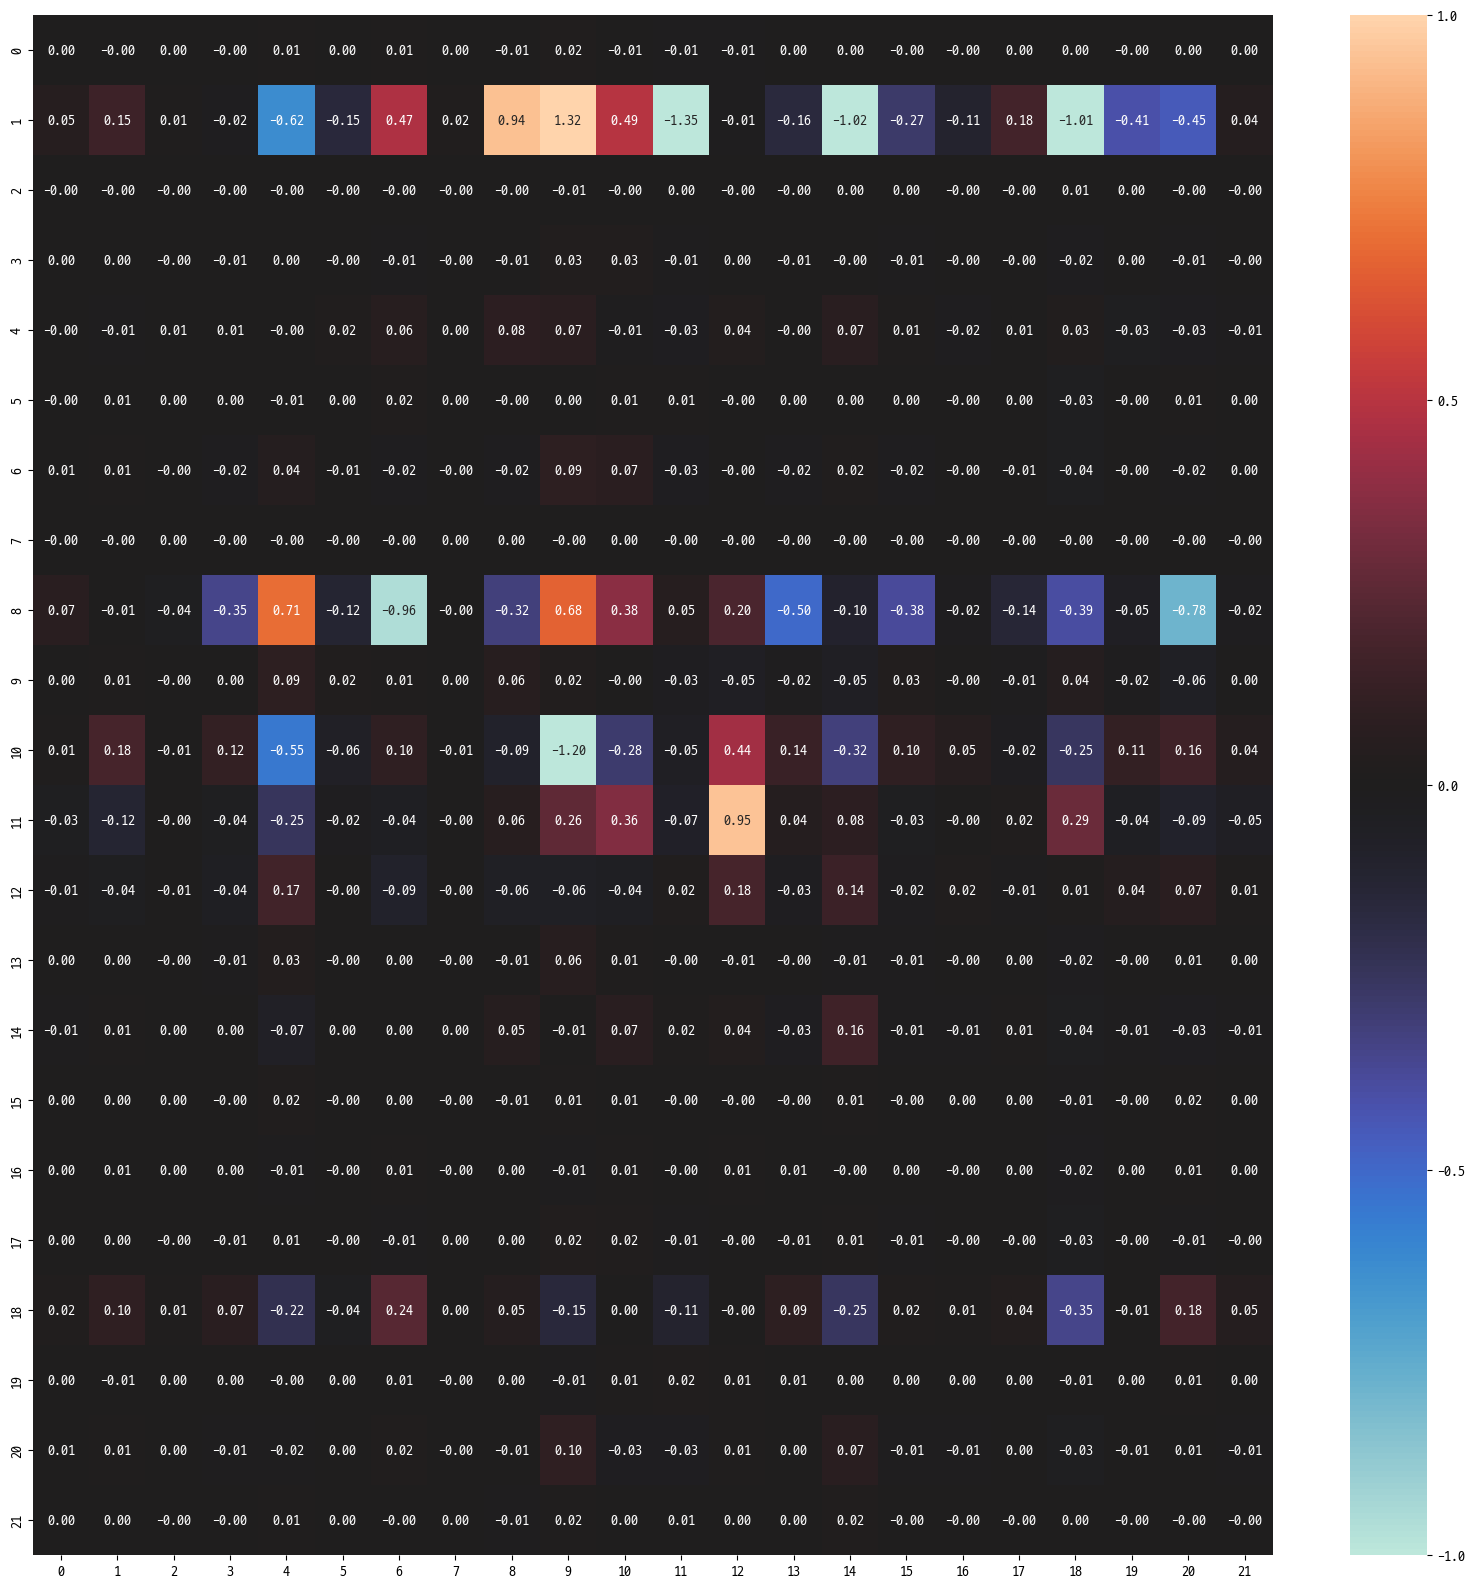

In [179]:
# sns.heatmap(res.coefs[0])
fig = plt.figure( figsize=(20,20))
sns.heatmap(res.coefs[0], annot=True, fmt=".2f", vmin=-1, vmax=1, cbar_kws={'ticks': [-1, -0.5, 0, 0.5, 1]}, center=0)
plt.show()


In [270]:
pivot_NS.iloc[:2].T.head()

item_id,AANGBULD,ATLDMDBO
ym,,
2022-01-01,14276.0,143097177.0
2022-02-01,52347.0,103568323.0
2022-03-01,53549.0,118403737.0
2022-04-01,0.0,121873741.0
2022-05-01,26997.0,115024617.0


In [286]:
x = [1,2,3,4,5,6,7,8,9,10]; x[-3:] # [8, 9, 10]
print(pivot_NS.iloc[:2].T.values.shape, best_lag)
pivot_NS.iloc[:2].T.values[-best_lag:]

(43, 2) 3


array([[       0., 37136720.],
       [  441275., 32181798.],
       [  533478., 57090235.]])

In [280]:
# =======================================================
# 6. VAR 자동 Lag 선택 (AIC 기반)
# =======================================================
print("\n===== VAR Lag Order Selection (AIC 기반) =====")
model = VAR(pivot_NS.iloc[:2].T)
#lag_selection = model.select_order(maxlags=15)
lag_selection = model.select_order(maxlags=6)
print(lag_selection.summary())

best_lag = lag_selection.aic
print(f"\n🔎 AIC 기준 최적 lag = {best_lag}\n")


# VAR 모델 적합
var_model = model.fit(best_lag)
print(var_model.summary())

forecast = var_model.forecast(pivot_NS.iloc[:2].T.values[-best_lag:], steps=2)
print("\nVAR Forecast (2 steps):\n", forecast)


===== VAR Lag Order Selection (AIC 기반) =====
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       58.02       58.11   1.583e+25       58.05
1       57.46      57.73*   9.055e+24       57.56
2       57.44       57.88   8.869e+24       57.59
3      57.32*       57.93  7.929e+24*      57.54*
4       57.46       58.24   9.149e+24       57.73
5       57.62       58.58   1.094e+25       57.96
6       57.75       58.88   1.281e+25       58.15
-------------------------------------------------

🔎 AIC 기준 최적 lag = 3

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Nov, 2025
Time:                     15:47:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    57.8800
Nobs:                     40.0000    HQIC:                   57.5026


/home/yypark/miniconda3/envs/ai_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 4. 회귀 모델 학습
- 시계열 데이터 안에서 '한 달 뒤 총 무역량(value)을 맞추는 문제'로 self-supervised 학습
- 탐색된 모든 공행성쌍 (A,B)에 대해 월 t마다 학습 샘플 생성
- input X:
1) B_t (현재 총 무역량(value))
2) B_{t-1} (직전 달 총 무역량(value))
3) A_{t-lag} (lag 반영된 총 무역량(value))
4) max_corr, best_lag (관계 특성)
- target y:
1) B_{t+1} (다음 달 총 무역량(value))
- 이러한 모든 샘플을 합쳐 LinearRegression 회귀 모델을 학습

In [6]:
def build_training_data(pivot, pairs):
    """
    공행성쌍 + 시계열을 이용해 (X, y) 학습 데이터를 만드는 함수
    input X:
      - b_t, b_t_1, a_t_lag, max_corr, best_lag
    target y:
      - b_t_plus_1
    """
    months = pivot.columns.to_list()
    n_months = len(months)

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t+1이 존재하고, t-lag >= 0인 구간만 학습에 사용
        for t in range(max(lag, 1), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            b_t_plus_1 = b_series[t + 1]

            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),
                "target": b_t_plus_1,
            })

    df_train = pd.DataFrame(rows)
    return df_train

df_train_model = build_training_data(pivot, pairs)
print('생성된 학습 데이터의 shape :', df_train_model.shape)
df_train_model.head()

생성된 학습 데이터의 shape : (54743, 6)


,b_t,b_t_1,a_t_lag,max_corr,best_lag,target
0,582317.0,539873.0,14276.0,-0.443984,5.0,759980.0
1,759980.0,582317.0,52347.0,-0.443984,5.0,216019.0
2,216019.0,759980.0,53549.0,-0.443984,5.0,537693.0
3,537693.0,216019.0,0.0,-0.443984,5.0,205326.0
4,205326.0,537693.0,26997.0,-0.443984,5.0,169440.0


In [7]:
# 회귀모델 학습
feature_cols = ['b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag']

train_X = df_train_model[feature_cols].values
train_y = df_train_model["target"].values

reg = LinearRegression()
reg.fit(train_X, train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## 5. 회귀 모델 추론 및 제출(submission) 파일 생성
- 탐색된 공행성 쌍에 대해 후행 품목(following_item_id)에 대한 2025년 8월 총 무역량(value) 예측

In [8]:
def predict(pivot, pairs, reg):
    months = pivot.columns.to_list()
    n_months = len(months)

    # 가장 마지막 두 달 index (2025-7, 2025-6)
    t_last = n_months - 1
    t_prev = n_months - 2

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        # t_last - lag 가 0 이상인 경우만 예측
        if t_last - lag < 0:
            continue

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        X_test = np.array([[b_t, b_t_1, a_t_lag, corr, float(lag)]])
        y_pred = reg.predict(X_test)[0]

        # (후처리 1) 음수 예측 → 0으로 변환
        # (후처리 2) 소수점 → 정수 변환 (무역량은 정수 단위)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    df_pred = pd.DataFrame(preds)
    return df_pred

In [9]:
submission = predict(pivot, pairs, reg)
submission.head()

1425it [00:00, 4715.18it/s]


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,360075
1,AANGBULD,DEWLVASR,610115
2,AANGBULD,DNMPSKTB,4999179
3,AANGBULD,EVBVXETX,4904136
4,AANGBULD,FTSVTTSR,387062


In [10]:
submission.to_csv('./baseline_submit.csv', index=False)